# Team 1: From black box to explanable AI: the trade-off between accuracy of complexity


In the project, we are exploring multiple machine learning methods spanning different ranges of explainability, complexity, and accuracy. Specifically, we will explore three types of machine learning models, which are neural networks (deterministic, black box), Gaussian process regression (probablistic, model data dependencies), and symbolic regression (output functions explicitly), and finally compare their performances on the accuracy-complexity axises.

# 0. Setup workspace and Import packages 

In [1]:
# load shap and PySR
!pip install -U pysr
!pip install shap

  Using cached pysr-1.5.2-py3-none-any.whl.metadata (54 kB)
  Using cached juliacall-0.9.24-py3-none-any.whl.metadata (4.5 kB)
  Using cached juliapkg-0.1.16-py3-none-any.whl.metadata (6.2 kB)
  Using cached semver-3.0.4-py3-none-any.whl.metadata (6.8 kB)
Using cached pysr-1.5.2-py3-none-any.whl (93 kB)
Using cached juliacall-0.9.24-py3-none-any.whl (11 kB)
Using cached juliapkg-0.1.16-py3-none-any.whl (16 kB)
Using cached semver-3.0.4-py3-none-any.whl (17 kB)
  Using cached shap-0.47.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (25 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
Using cached shap-0.47.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (967 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)


In [2]:
%%capture
import importlib

# Check and install torch
if importlib.util.find_spec("torch") is None:
    !pip install torch

# Check and install zarr
if importlib.util.find_spec("zarr") is None:
    !pip install zarr

# Ensure xarray is upgraded
!pip install --upgrade xarray

In [3]:
import pysr
import sympy
from pysr import PySRRegressor
import os
import numpy as np
import matplotlib.pyplot as plt
import copy as copy
import matplotlib as mpl
import netCDF4 as ncd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
from torch import nn, optim
import matplotlib.cm as cm
import copy as copy
import multiprocessing as mp
from scipy import stats
import time as time
import matplotlib.font_manager
import seaborn as sns
import pandas as pd
from tqdm import tqdm  # Import tqdm for the progress bar
import xarray as xr
import requests
from datetime import datetime
import warnings
import gpytorch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import shap
import time
import random
from sklearn.model_selection import KFold

warnings.filterwarnings("ignore", category=FutureWarning)

today = datetime.today()
torch.cuda.empty_cache()

cwd=os.getcwd()
parent_dir = os.path.dirname(cwd)
os.chdir(parent_dir)
cwd = parent_dir
print("Current working directory:", os.getcwd())

# custom modules
import lib.func_file as ff
from lib.visual_figure4 import performance_sigma_point, performance_sigma_point_batched
from lib.visual_figure3 import score_eval, save_losses_by_seed, plot_n1_scores

np.random.seed(100)

cwd_data = cwd + '/data/'
## 
cwd_output = cwd + '/output/'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

[juliapkg] Found dependencies: /srv/conda/envs/notebook/lib/python3.12/site-packages/juliacall/juliapkg.json
[juliapkg] Found dependencies: /srv/conda/envs/notebook/lib/python3.12/site-packages/juliapkg/juliapkg.json
[juliapkg] Found dependencies: /srv/conda/envs/notebook/lib/python3.12/site-packages/pysr/juliapkg.json
[juliapkg] Locating Julia =1.10.0, ^1.10.3
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] WARNING: About to install Julia 1.11.4 to /srv/conda/envs/notebook/julia_env/pyjuliapkg/install.
[juliapkg]   If you use juliapkg in more than one environment, you are likely to
[juliapkg]   have Julia installed in multiple locations. It is recommended to
[juliapkg]   install JuliaUp (https://github.com/JuliaLang/juliaup) or Julia
[juliapkg]   (https://julialang.org/downloads) yourself.
[juliapkg] Downloading Julia from https://julialang-s3.julialang.org/bin/linux/x64/1.11/julia-1.11.4-linux-x86_64.tar.gz
             download

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `/srv/conda/envs/notebook/julia_env/Project.toml`
  [6099a3de] + PythonCall v0.9.24
  [8254be44] + SymbolicRegression v1.9.0
  [9e88b42a] ~ Serialization ⇒ v1.11.0
    Updating `/srv/conda/envs/notebook/julia_env/Manifest.toml`
  [47edcb42] + ADTypes v1.14.0
  [79e6a3ab] + Adapt v4.3.0
  [66dad0bd] + AliasTables v1.1.3
  [4fba245c] + ArrayInterface v7.18.0
  [d360d2e6] + ChainRulesCore v1.25.1
  [bbf7d656] + CommonSubexpressions v0.3.1
  [34da2185] + Compat v4.16.0
  [992eb4ea] + CondaPkg v0.2.26
  [187b0558] + ConstructionBase v1.5.8
  [9a962f9c] + DataAPI v1.16.0
  [864edb3b] + DataStructures v0.18.22
  [e2d170a0] + DataValueInterfaces v1.0.0
  [163ba53b] + DiffResults v1.1.0
  [b552c78f] + DiffRules v1.15.1
  [a0c0ee7d] + DifferentiationInterface v0.6.48
  [8d63f2c5] + DispatchDoctor v0.4.19
  [ffbed154] + DocStringExtensions v0.9.3
  [7317a516] + DynamicDiff v0.2.0
  [a40a106e]

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
Current working directory: /home/jovyan/LEAPCourse-Climate-Pred-Challenges/Project-StarterCodes/Project2-Parameterization/ML_Project2_Team1


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Preparation

In [5]:
store = 'https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/sf_training_data.zarr'
d = xr.open_dataset(store, engine='zarr', chunks={})

# d=ncd.Dataset(cwd_data+'training_data_for_SF_hbl_gaps_filled.nc').variables

def corio(lat):
    return  2*(2*np.pi/(24*60*60)) * np.sin(lat*(np.pi/180))

l0=corio(d['l'][:])
b00=d['b0'][:]
ustar0=d['ustar'][:]
h0=d['h'][:]
lat0=d['lat'][:]
heat0=d['heat'][:]
tx0=d['tx'][:] 
tx0=np.round(tx0,2)
SF0=d['SF'][:] 

In [6]:
ind101=np.where(np.abs(heat0)<601)[0]
ind1=ind101 
ind2=np.where(tx0<1.2)[0]
ind3=np.where(h0>29)[0]
ind4=np.where(h0<301)[0]

ind5=np.intersect1d(ind1,ind2)
ind6=np.intersect1d(ind3,ind5)
ind7=np.intersect1d(ind4,ind6)

In [7]:
mm1=0; mm2=16  #0; 16
data_load_main=np.zeros([len(h0[ind7]),4+mm2-mm1])
data_load_main[:,0]=l0[ind7]
data_load_main[:,1]=b00[ind7]
data_load_main[:,2]=ustar0[ind7]
data_load_main[:,3]=h0[ind7]
data_load_main[:,4:(mm2-mm1+4)]=SF0[ind7,mm1:mm2]

data_forc=np.zeros([len(ind7),3])
data_forc[:,0]=lat0[ind7]
data_forc[:,1]=heat0[ind7]
data_forc[:,2]=tx0[ind7]

data_load3=copy.deepcopy(data_load_main)

print('started')

data, x,y, stats, k_mean, k_std=ff.preprocess_train_data(data_load3)

started


In [8]:
# valid_data=np.loadtxt(cwd_data+'data_testing_4_paper.txt')[:,3:]

url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
valid_data = np.loadtxt(url, delimiter=None)[:,3:] 

ind3=np.where(valid_data[:,3]>29)[0]
ind4=np.where(valid_data[:,3]<301)[0]
ind=np.intersect1d(ind3,ind4)

valid_x=valid_data[ind,0:4]

valid_x[:,0]=(valid_x[:,0]-stats[0])/stats[1]
valid_x[:,1]=(valid_x[:,1]-stats[2])/stats[3]
valid_x[:,2]=(valid_x[:,2]-stats[4])/stats[5]
valid_x[:,3]=(valid_x[:,3]-stats[6])/stats[7]
k_mean_test=np.zeros(16)
valid_y=valid_data[ind,5:]

for i in range(len(valid_y)):
    valid_y[i,:]=np.log(valid_y[i,:]/np.max(valid_y[i,:]))

for i in range(16):
    valid_y[:,i]=(valid_y[:,i]-k_mean[i])/k_std[i]

In [9]:
x=torch.FloatTensor(x).to(device)
y=torch.FloatTensor(y).to(device)

valid_x=torch.FloatTensor(valid_x).to(device)
valid_y=torch.FloatTensor(valid_y).to(device)

# 1. Neural Network with Self-attention Mechanism

A Neural Network with a self-attention mechanism is designed to capture complex contextual relationships within the input data by dynamically assigning weights to different components. Unlike traditional architectures that process inputs uniformly, the self-attention module explicitly models the dependencies among various elements. This capability allows the network to focus on the most pertinent features, potentially leading to enhanced prediction accuracy. In this section, we aim to leverage this mechanism to predict shape function values and explore how context-aware feature weighting can contribute to improved model performance.

## 1.1 Neural Network Architecture

We increased the number of hidden layers to four and added self-attention mechanism with it. In stead of using RELU, we used Leaky ReLU, which offers a significant improvement over the traditional ReLU activation function by addressing the "dying ReLU" problem. While ReLU outputs zero for any negative input—potentially leading to inactive neurons that no longer update during training—Leaky ReLU assigns a small, non-zero slope (commonly around 0.01) to negative values. This modification allows for a non-zero gradient when the input is negative, which helps maintain the learning process for all neurons, improves gradient flow, and often results in faster convergence and enhanced overall performance.

In [28]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        # A simple two-layer attention module that produces channel-wise weights.
        self.attn = nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.ReLU(),
            nn.Linear(in_dim, in_dim),
            nn.Softmax(dim=-1)  # Normalize attention weights across the channel dimension
        )
    
    def forward(self, x):
        # x: shape (batch, in_dim)
        attn_weights = self.attn(x)  # Compute attention weights (batch, in_dim)
        out = x * attn_weights       # Reweight input features element-wise
        return out

class learnKappa_layers(nn.Module):
    def __init__(self, In_nodes, Hid, Out_nodes):
        super(learnKappa_layers, self).__init__()
        self.linear1 = nn.Linear(In_nodes, Hid)   # First layer: Input to hidden
        self.linear2 = nn.Linear(Hid, Hid)         # Second layer: Hidden to hidden
        self.linear3 = nn.Linear(Hid, Hid)         # Third layer: Hidden to hidden
        self.linear4 = nn.Linear(Hid, Hid)         # Fourth layer: Hidden to hidden
        self.linear5 = nn.Linear(Hid, Out_nodes)    # Output layer: Hidden to output
        self.dropout = nn.Dropout(0.25)             # Dropout for regularization
        self.leakyrelu = nn.LeakyReLU(negative_slope=0.01)  # LeakyReLU activation
        
        # Self-attention block that recalibrates the hidden features
        self.attention = SelfAttention(Hid)

    def forward(self, x):
        h1 = self.leakyrelu(self.linear1(x))
        h1 = self.dropout(h1)
        
        h2 = self.leakyrelu(self.linear2(h1))
        h2 = self.dropout(h2)
        
        h3 = self.leakyrelu(self.linear3(h2))
        h3 = self.dropout(h3)
        
        h4 = self.leakyrelu(self.linear4(h3))
        h4 = self.dropout(h4)
        
        # Apply self-attention to the output of the fourth hidden layer
        h4 = self.attention(h4)
        
        y_pred = self.linear5(h4)
        return y_pred

## 1.2 Model Training

In [29]:
def modeltrain_loss(In_nodes, Hid, Out_nodes, lr, epochs, x, y, valid_x, valid_y, model, k_std_y, k_mean, k_std, patience=10):
    # Initialize optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr)
    loss_fn = nn.L1Loss(reduction='mean')
    
    # Array to record epoch number, training loss, and validation loss for each epoch
    loss_array = torch.zeros([epochs, 3])
    
    best_loss = float('inf')
    no_improvement = 0
    best_model_state = None
    
    epoch_times = []  # To store runtime for each epoch
    
    # Reset maximum GPU memory counter (if using GPU)
    if torch.cuda.is_available():
        torch.cuda.reset_max_memory_allocated()
    
    # Start total training timer
    total_start_time = time.time()
    
    with tqdm(total=epochs, desc="Training Progress", unit="epoch") as pbar:
        for k in range(epochs):
            optimizer.zero_grad()
            
            # Start timer for this epoch
            epoch_start = time.time()
            
            # Forward pass for training and validation data
            y_pred = model(x)
            valid_pred = model(valid_x)
            
            # Compute loss for gradient computation and reporting
            loss = loss_fn(y_pred * k_std_y, y * k_std_y)
            loss_train = torch.mean(torch.abs(torch.exp(y_pred * k_std + k_mean) - torch.exp(y * k_std + k_mean)))
            loss_valid = torch.mean(torch.abs(torch.exp(valid_pred * k_std + k_mean) - torch.exp(valid_y * k_std + k_mean)))
            
            # Compute RMSE for training and validation (on the original scale)
            train_rmse = torch.sqrt(torch.mean((torch.exp(y_pred * k_std + k_mean) - torch.exp(y * k_std + k_mean)) ** 2))
            valid_rmse = torch.sqrt(torch.mean((torch.exp(valid_pred * k_std + k_mean) - torch.exp(valid_y * k_std + k_mean)) ** 2))
            
            # Backpropagation and parameter update
            loss.backward()
            optimizer.step()
            
            # End timer for this epoch and record the runtime
            epoch_end = time.time()
            epoch_times.append(epoch_end - epoch_start)
            
            # Record losses for this epoch
            loss_array[k, 0] = k  
            loss_array[k, 1] = loss_train.item()
            loss_array[k, 2] = loss_valid.item()
            
            # Update progress bar with loss values and RMSE values
            pbar.set_postfix(train_loss=loss_train.item(), valid_loss=loss_valid.item(), 
                             train_RMSE=f"{train_rmse.item():.4f}", valid_RMSE=f"{valid_rmse.item():.4f}",
                             patience_count=no_improvement)
            pbar.update(1)
            
            # Early stopping: update best loss and reset no_improvement counter if improved
            if loss_valid.item() < best_loss:
                best_loss = loss_valid.item()
                no_improvement = 0
                best_model_state = model.state_dict()
            else:
                no_improvement += 1
                
            # If no improvement for 'patience' epochs, stop training early
            if no_improvement >= patience:
                print(f"\nEarly stopping at epoch {k+1}. Validation loss has not improved for {patience} epochs.")
                break
            
            # Free memory by deleting intermediate variables
            del loss, y_pred
        
    # End total training timer
    total_end_time = time.time()
    total_time = total_end_time - total_start_time
    avg_epoch_time = sum(epoch_times) / len(epoch_times) if epoch_times else 0
    
    # Restore the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    # Get maximum GPU memory usage (in MB)
    if torch.cuda.is_available():
        max_gpu_mem = torch.cuda.max_memory_allocated() / (1024 ** 2)
    else:
        max_gpu_mem = None
    
    # Final evaluation: compute RMSE on the validation set using the best model
    final_valid_pred = model(valid_x)
    final_valid_rmse = torch.sqrt(torch.mean((torch.exp(final_valid_pred * k_std + k_mean) - torch.exp(valid_y * k_std + k_mean)) ** 2))
    
    # Print summary statistics
    print("Total training time (seconds):", total_time)
    print("Average epoch time (seconds):", avg_epoch_time)
    if max_gpu_mem is not None:
        print("Maximum GPU memory usage (MB):", max_gpu_mem)
    print("Final Validation RMSE:", final_valid_rmse.item())
    
    return model, loss_array[:k, :]

## 1.3 Random search

Random search is a hyperparameter optimization technique that involves randomly sampling configurations from a predefined search space. Unlike grid search, which exhaustively evaluates every combination of parameters, random search selects combinations at random. This approach can be particularly efficient when only a subset of hyperparameters significantly impacts the model's performance, as it allows for a broader exploration of the parameter space with fewer evaluations. To ensure robust performance evaluation, random search is often combined with cross-validation, which assesses each sampled configuration across multiple data splits. This helps mitigate overfitting to any particular subset of the data and provides a more reliable estimate of model performance. Random search is also highly scalable and can be easily parallelized, making it a practical and flexible choice for tuning machine learning models.

In [11]:
epochs, k_points, lr=3000, 16, 1e-03

kms1=1.0 #0.1
kms2=1.0 #100.0
kmask=np.array([kms1,kms1,kms2,kms2,kms2,kms2,kms2,kms2,kms2,kms1,kms1,kms1,kms1,kms1,kms1,kms1])

torch.manual_seed(10)

k_mean_c=torch.tensor(k_mean).float().to(device)
k_std_c=torch.tensor(k_std).float().to(device)

# Define search space for the number of hidden nodes and layers
hid_array = np.array([2, 4, 8, 16, 32, 64])
layer_options = np.array([2, 3, 4])  # Options for the number of hidden layers

num_random_trials = 10   # Number of random search trials (adjust as needed)
num_folds = 5            # Number of folds for cross-validation

# List to store the results of each random search trial
random_search_results = []

# Fix random seeds for reproducibility
random.seed(10)
torch.manual_seed(10)

# Set up KFold cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Define the mandatory combination
mandatory_combination = {'hidden_nodes': 64, 'layers': 4}

# Track used hyperparameter combinations to ensure uniqueness
used_combinations = set()

# Perform random search and cross-validation on the training data (x, y)
for trial in range(num_random_trials):
    # Track total time for each trial
    trial_start_time = time.time()
    
    # Force one trial to have mandatory combination
    if trial == 0:
        h = mandatory_combination['hidden_nodes']
        selected_layers = mandatory_combination['layers']
    else:
        # Ensure unique hyperparameter combinations
        while True:
            h = random.choice(hid_array)
            selected_layers = int(random.choice(layer_options))
            
            # Create a unique combination key
            combination_key = (h, selected_layers)
            
            # If this combination hasn't been used before, use it
            if combination_key not in used_combinations:
                used_combinations.add(combination_key)
                break
        
    in_nod, hid_nod, o_nod = 4, h, 16
    print(f"Trial {trial+1}: layers = {selected_layers}, hidden nodes = {h}")

    fold_val_losses = []  # To record the validation loss for each fold
    
    # Tracking time and GPU memory for the trial
    trial_epoch_times = []
    trial_max_gpu_mem = 0

    # Perform K-Fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(range(x.shape[0])), 1):
        # Construct training and validation sets for the current fold (x and y are torch.Tensors)
        train_x = x[train_idx]
        train_y = y[train_idx]
        val_x = x[val_idx]
        val_y = y[val_idx]

        # Construct the model for the current trial using the selected number of hidden layers.
        if selected_layers == 2:
            model = ff.learnKappa_layers2(in_nod, hid_nod, o_nod)
        elif selected_layers == 3:
            model = ff.learnKappa_layers3(in_nod, hid_nod, o_nod)
        elif selected_layers == 4:
            model = ff.learnKappa_layers4(in_nod, hid_nod, o_nod)
        else:
            raise ValueError("Selected number of layers is not supported.")

        model = model.to(device)

        # Train the model using the modeltrain_loss function
        model, loss_array = modeltrain_loss(
            in_nod, hid_nod, o_nod, lr, epochs,
            train_x, train_y, val_x, val_y, model,
            torch.tensor(kmask).float().to(device),
            k_mean_c, k_std_c
        )

        # Extract the final validation loss from the third column of loss_array
        final_val_loss = loss_array[-1, 2] if loss_array.shape[0] > 0 else float('inf')
        fold_val_losses.append(final_val_loss)

        # Save the current fold's model and loss array to the designated directory
        fold_dir = os.path.join(cwd_output,
                                f"random_search_trial_{trial+1}_layers_{selected_layers}_hidden_{h}",
                                f"fold_{fold}")
        os.makedirs(fold_dir, exist_ok=True)
        model_path = os.path.join(fold_dir, 'model.pt')
        loss_path = os.path.join(fold_dir, 'loss_array.txt')
        torch.save(model, model_path)
        np.savetxt(loss_path, loss_array.detach().numpy())

        # Track epoch times and GPU memory for the trial
        if hasattr(model, 'epoch_times'):
            trial_epoch_times.extend(model.epoch_times)
        
        # Track maximum GPU memory usage
        if torch.cuda.is_available():
            trial_max_gpu_mem = max(trial_max_gpu_mem, torch.cuda.max_memory_allocated() / (1024 ** 2))
            torch.cuda.reset_max_memory_allocated()

        # Clean up the model and free memory for the current fold
        del model, loss_array
        torch.cuda.empty_cache()

    # Compute the average cross-validation validation loss for this hyperparameter configuration
    avg_val_loss = np.mean(fold_val_losses)
    
    # Calculate total trial time
    trial_end_time = time.time()
    total_trial_time = trial_end_time - trial_start_time
    
    # Calculate average epoch time for the trial
    avg_trial_epoch_time = np.mean(trial_epoch_times) if trial_epoch_times else 0
    
    random_search_results.append({
        'trial': trial+1,
        'layers': selected_layers,
        'hidden_nodes': h,
        'avg_val_loss': avg_val_loss,
        'fold_losses': fold_val_losses,
        'total_time': total_trial_time,
        'avg_epoch_time': avg_trial_epoch_time,
        'max_gpu_mem': trial_max_gpu_mem
    })

    print(f"Trial {trial+1} average CV validation loss: {avg_val_loss}")
    print(f"Trial {trial+1} total time: {total_trial_time:.2f} seconds")
    print(f"Trial {trial+1} average epoch time: {avg_trial_epoch_time:.4f} seconds")
    print(f"Trial {trial+1} max GPU memory: {trial_max_gpu_mem:.2f} MB\n")

# Output all random search trial results
print("Random Search with Cross Validation Results:")
for res in random_search_results:
    print(res)

Trial 1: layers = 4, hidden nodes = 64


Training Progress:  34%|███▍      | 1014/3000 [01:34<03:04, 10.75epoch/s, patience_count=9, train_RMSE=0.0582, train_loss=0.0277, valid_RMSE=0.0580, valid_loss=0.0277]



Early stopping at epoch 1014. Validation loss has not improved for 10 epochs.
Total training time (seconds): 94.31865048408508
Average epoch time (seconds): 0.0034645548938999514
Maximum GPU memory usage (MB): 3193.24169921875
Final Validation RMSE: 0.05792701989412308


Training Progress:  24%|██▍       | 713/3000 [01:06<03:32, 10.76epoch/s, patience_count=9, train_RMSE=0.0640, train_loss=0.0295, valid_RMSE=0.0641, valid_loss=0.0296]



Early stopping at epoch 713. Validation loss has not improved for 10 epochs.
Total training time (seconds): 66.24204516410828
Average epoch time (seconds): 0.003023976865022079
Maximum GPU memory usage (MB): 3192.85009765625
Final Validation RMSE: 0.06396444141864777


Training Progress:  20%|█▉        | 588/3000 [00:54<03:44, 10.74epoch/s, patience_count=9, train_RMSE=0.0687, train_loss=0.0311, valid_RMSE=0.0687, valid_loss=0.0311]



Early stopping at epoch 588. Validation loss has not improved for 10 epochs.
Total training time (seconds): 54.72658824920654
Average epoch time (seconds): 0.0030569985610287204
Maximum GPU memory usage (MB): 3192.8388671875
Final Validation RMSE: 0.06840734928846359


Training Progress:  22%|██▏       | 664/3000 [01:01<03:37, 10.74epoch/s, patience_count=9, train_RMSE=0.0660, train_loss=0.0305, valid_RMSE=0.0658, valid_loss=0.0305]



Early stopping at epoch 664. Validation loss has not improved for 10 epochs.
Total training time (seconds): 61.8233277797699
Average epoch time (seconds): 0.003039327730615455
Maximum GPU memory usage (MB): 3192.0537109375
Final Validation RMSE: 0.06623886525630951


Training Progress:  34%|███▎      | 1008/3000 [01:33<03:05, 10.76epoch/s, patience_count=9, train_RMSE=0.0582, train_loss=0.0277, valid_RMSE=0.0580, valid_loss=0.0276]



Early stopping at epoch 1008. Validation loss has not improved for 10 epochs.
Total training time (seconds): 93.70924234390259
Average epoch time (seconds): 0.003038222354555887
Maximum GPU memory usage (MB): 3192.83984375
Final Validation RMSE: 0.058247193694114685
Trial 1 average CV validation loss: 0.029344454407691956
Trial 1 total time: 371.78 seconds
Trial 1 average epoch time: 0.0000 seconds
Trial 1 max GPU memory: 3193.24 MB

Trial 2: layers = 2, hidden nodes = 32


Training Progress:  18%|█▊        | 549/3000 [00:18<01:23, 29.22epoch/s, patience_count=9, train_RMSE=0.0975, train_loss=0.0407, valid_RMSE=0.0993, valid_loss=0.0408]



Early stopping at epoch 549. Validation loss has not improved for 10 epochs.
Total training time (seconds): 18.79217767715454
Average epoch time (seconds): 0.0021444292016368095
Maximum GPU memory usage (MB): 1231.13818359375
Final Validation RMSE: 0.09884633868932724


Training Progress:  20%|█▉        | 595/3000 [00:20<01:22, 29.23epoch/s, patience_count=9, train_RMSE=0.0886, train_loss=0.0394, valid_RMSE=0.0893, valid_loss=0.0395]



Early stopping at epoch 595. Validation loss has not improved for 10 epochs.
Total training time (seconds): 20.36107110977173
Average epoch time (seconds): 0.002168315598944656
Maximum GPU memory usage (MB): 1232.28759765625
Final Validation RMSE: 0.09016043692827225


Training Progress:  26%|██▌       | 786/3000 [00:26<01:15, 29.25epoch/s, patience_count=9, train_RMSE=0.0890, train_loss=0.0383, valid_RMSE=0.0876, valid_loss=0.0383]



Early stopping at epoch 786. Validation loss has not improved for 10 epochs.
Total training time (seconds): 26.87398076057434
Average epoch time (seconds): 0.0021693048283040676
Maximum GPU memory usage (MB): 1231.13818359375
Final Validation RMSE: 0.08960776776075363


Training Progress:  26%|██▌       | 771/3000 [00:26<01:16, 29.26epoch/s, patience_count=9, train_RMSE=0.0938, train_loss=0.0387, valid_RMSE=0.0927, valid_loss=0.0388]



Early stopping at epoch 771. Validation loss has not improved for 10 epochs.
Total training time (seconds): 26.350111961364746
Average epoch time (seconds): 0.002206797729670306
Maximum GPU memory usage (MB): 1232.28759765625
Final Validation RMSE: 0.09359485656023026


Training Progress:  29%|██▉       | 867/3000 [00:29<01:12, 29.24epoch/s, patience_count=9, train_RMSE=0.0790, train_loss=0.0373, valid_RMSE=0.0787, valid_loss=0.0372]



Early stopping at epoch 867. Validation loss has not improved for 10 epochs.
Total training time (seconds): 29.651644229888916
Average epoch time (seconds): 0.002248977432338974
Maximum GPU memory usage (MB): 1231.13818359375
Final Validation RMSE: 0.07882232964038849
Trial 2 average CV validation loss: 0.03889907896518707
Trial 2 total time: 122.34 seconds
Trial 2 average epoch time: 0.0000 seconds
Trial 2 max GPU memory: 1232.29 MB

Trial 3: layers = 3, hidden nodes = 16


Training Progress:  18%|█▊        | 552/3000 [00:16<01:13, 33.29epoch/s, patience_count=9, train_RMSE=0.1073, train_loss=0.0496, valid_RMSE=0.1095, valid_loss=0.0495]



Early stopping at epoch 552. Validation loss has not improved for 10 epochs.
Total training time (seconds): 16.58117985725403
Average epoch time (seconds): 0.002537581799686819
Maximum GPU memory usage (MB): 1079.32861328125
Final Validation RMSE: 0.10697390884160995


Training Progress:  15%|█▍        | 444/3000 [00:13<01:16, 33.29epoch/s, patience_count=9, train_RMSE=0.1253, train_loss=0.0532, valid_RMSE=0.1315, valid_loss=0.0533]



Early stopping at epoch 444. Validation loss has not improved for 10 epochs.
Total training time (seconds): 13.338690757751465
Average epoch time (seconds): 0.002494912426750939
Maximum GPU memory usage (MB): 1077.73779296875
Final Validation RMSE: 0.12801410257816315


Training Progress:  18%|█▊        | 551/3000 [00:16<01:13, 33.26epoch/s, patience_count=9, train_RMSE=0.1402, train_loss=0.052, valid_RMSE=0.1390, valid_loss=0.0522] 



Early stopping at epoch 551. Validation loss has not improved for 10 epochs.
Total training time (seconds): 16.56792426109314
Average epoch time (seconds): 0.0025212319057346905
Maximum GPU memory usage (MB): 1079.32861328125
Final Validation RMSE: 0.1372021585702896


Training Progress:  14%|█▍        | 418/3000 [00:12<01:17, 33.27epoch/s, patience_count=9, train_RMSE=0.1252, train_loss=0.0527, valid_RMSE=0.1301, valid_loss=0.0529]



Early stopping at epoch 418. Validation loss has not improved for 10 epochs.
Total training time (seconds): 12.565820455551147
Average epoch time (seconds): 0.0024973205402136988
Maximum GPU memory usage (MB): 1077.73779296875
Final Validation RMSE: 0.12145557254552841


Training Progress:  23%|██▎       | 701/3000 [00:21<01:09, 33.29epoch/s, patience_count=9, train_RMSE=0.1054, train_loss=0.0481, valid_RMSE=0.1034, valid_loss=0.048] 



Early stopping at epoch 701. Validation loss has not improved for 10 epochs.
Total training time (seconds): 21.062035083770752
Average epoch time (seconds): 0.0024960190695464696
Maximum GPU memory usage (MB): 1079.32861328125
Final Validation RMSE: 0.10373444110155106
Trial 3 average CV validation loss: 0.051159679889678955
Trial 3 total time: 80.41 seconds
Trial 3 average epoch time: 0.0000 seconds
Trial 3 max GPU memory: 1079.33 MB

Trial 4: layers = 3, hidden nodes = 4


Training Progress:  17%|█▋        | 523/3000 [00:11<00:54, 45.18epoch/s, patience_count=9, train_RMSE=0.1966, train_loss=0.0844, valid_RMSE=0.1964, valid_loss=0.0844]



Early stopping at epoch 523. Validation loss has not improved for 10 epochs.
Total training time (seconds): 11.576968908309937
Average epoch time (seconds): 0.0026376179025916252
Maximum GPU memory usage (MB): 738.99560546875
Final Validation RMSE: 0.204289972782135


Training Progress:  18%|█▊        | 552/3000 [00:12<00:54, 45.29epoch/s, patience_count=9, train_RMSE=0.1438, train_loss=0.0814, valid_RMSE=0.1440, valid_loss=0.0816]



Early stopping at epoch 552. Validation loss has not improved for 10 epochs.
Total training time (seconds): 12.19104552268982
Average epoch time (seconds): 0.0025150067564369974
Maximum GPU memory usage (MB): 738.20068359375
Final Validation RMSE: 0.14385677874088287


Training Progress:  31%|███       | 934/3000 [00:20<00:45, 45.18epoch/s, patience_count=9, train_RMSE=0.1458, train_loss=0.0706, valid_RMSE=0.1472, valid_loss=0.0709]



Early stopping at epoch 934. Validation loss has not improved for 10 epochs.
Total training time (seconds): 20.67341184616089
Average epoch time (seconds): 0.0025499341829941153
Maximum GPU memory usage (MB): 738.99560546875
Final Validation RMSE: 0.1470736861228943


Training Progress:  10%|█         | 300/3000 [00:06<00:59, 45.23epoch/s, patience_count=9, train_RMSE=0.1633, train_loss=0.0884, valid_RMSE=0.1635, valid_loss=0.0883]



Early stopping at epoch 300. Validation loss has not improved for 10 epochs.
Total training time (seconds): 6.634657859802246
Average epoch time (seconds): 0.0025485626856486003
Maximum GPU memory usage (MB): 738.20068359375
Final Validation RMSE: 0.16299127042293549


Training Progress:  22%|██▏       | 646/3000 [00:14<00:52, 45.20epoch/s, patience_count=9, train_RMSE=0.1337, train_loss=0.0725, valid_RMSE=0.1336, valid_loss=0.0724]



Early stopping at epoch 646. Validation loss has not improved for 10 epochs.
Total training time (seconds): 14.293846368789673
Average epoch time (seconds): 0.002545453815637358
Maximum GPU memory usage (MB): 738.99560546875
Final Validation RMSE: 0.13352321088314056
Trial 4 average CV validation loss: 0.07952171564102173
Trial 4 total time: 65.63 seconds
Trial 4 average epoch time: 0.0000 seconds
Trial 4 max GPU memory: 739.00 MB

Trial 5: layers = 2, hidden nodes = 64


Training Progress:  22%|██▏       | 646/3000 [00:34<02:05, 18.73epoch/s, patience_count=9, train_RMSE=0.0688, train_loss=0.0326, valid_RMSE=0.0690, valid_loss=0.0326]



Early stopping at epoch 646. Validation loss has not improved for 10 epochs.
Total training time (seconds): 34.48454999923706
Average epoch time (seconds): 0.0022423510950047164
Maximum GPU memory usage (MB): 1839.919921875
Final Validation RMSE: 0.06882309168577194


Training Progress:  28%|██▊       | 855/3000 [00:45<01:54, 18.74epoch/s, patience_count=9, train_RMSE=0.0647, train_loss=0.0305, valid_RMSE=0.0647, valid_loss=0.0306]



Early stopping at epoch 855. Validation loss has not improved for 10 epochs.
Total training time (seconds): 45.624743938446045
Average epoch time (seconds): 0.0022632275408471536
Maximum GPU memory usage (MB): 1839.1337890625
Final Validation RMSE: 0.06483824551105499


Training Progress:  28%|██▊       | 833/3000 [00:44<01:55, 18.77epoch/s, patience_count=9, train_RMSE=0.0633, train_loss=0.0305, valid_RMSE=0.0634, valid_loss=0.0305]



Early stopping at epoch 833. Validation loss has not improved for 10 epochs.
Total training time (seconds): 44.38811779022217
Average epoch time (seconds): 0.002274178370994394
Maximum GPU memory usage (MB): 1839.919921875
Final Validation RMSE: 0.0632384717464447


Training Progress:  25%|██▌       | 759/3000 [00:40<01:59, 18.76epoch/s, patience_count=9, train_RMSE=0.0650, train_loss=0.0307, valid_RMSE=0.0651, valid_loss=0.0307]



Early stopping at epoch 759. Validation loss has not improved for 10 epochs.
Total training time (seconds): 40.467790842056274
Average epoch time (seconds): 0.002284287464006145
Maximum GPU memory usage (MB): 1839.1337890625
Final Validation RMSE: 0.06508355587720871


Training Progress:  23%|██▎       | 684/3000 [00:36<02:03, 18.75epoch/s, patience_count=9, train_RMSE=0.0648, train_loss=0.0311, valid_RMSE=0.0645, valid_loss=0.031] 



Early stopping at epoch 684. Validation loss has not improved for 10 epochs.
Total training time (seconds): 36.476606130599976
Average epoch time (seconds): 0.0022926368908575403
Maximum GPU memory usage (MB): 1839.919921875
Final Validation RMSE: 0.06452707946300507
Trial 5 average CV validation loss: 0.031068716198205948
Trial 5 total time: 201.78 seconds
Trial 5 average epoch time: 0.0000 seconds
Trial 5 max GPU memory: 1839.92 MB

Trial 6: layers = 4, hidden nodes = 2


Training Progress:  26%|██▋       | 791/3000 [00:18<00:50, 43.84epoch/s, patience_count=9, train_RMSE=0.1586, train_loss=0.0891, valid_RMSE=0.1585, valid_loss=0.089] 



Early stopping at epoch 791. Validation loss has not improved for 10 epochs.
Total training time (seconds): 18.045193910598755
Average epoch time (seconds): 0.002880016862215797
Maximum GPU memory usage (MB): 700.1953125
Final Validation RMSE: 0.15841946005821228


Training Progress:  27%|██▋       | 814/3000 [00:18<00:49, 43.80epoch/s, patience_count=9, train_RMSE=0.1629, train_loss=0.0924, valid_RMSE=0.1629, valid_loss=0.0923]



Early stopping at epoch 814. Validation loss has not improved for 10 epochs.
Total training time (seconds): 18.586617946624756
Average epoch time (seconds): 0.0028798190615979694
Maximum GPU memory usage (MB): 700.19580078125
Final Validation RMSE: 0.16285142302513123


Training Progress:  57%|█████▋    | 1715/3000 [00:39<00:29, 43.86epoch/s, patience_count=9, train_RMSE=0.1644, train_loss=0.093, valid_RMSE=0.1646, valid_loss=0.0932] 



Early stopping at epoch 1715. Validation loss has not improved for 10 epochs.
Total training time (seconds): 39.1026246547699
Average epoch time (seconds): 0.0028785563766435007
Maximum GPU memory usage (MB): 700.1953125
Final Validation RMSE: 0.16464591026306152


Training Progress:  61%|██████    | 1824/3000 [00:41<00:26, 43.86epoch/s, patience_count=9, train_RMSE=0.1644, train_loss=0.093, valid_RMSE=0.1645, valid_loss=0.093]  



Early stopping at epoch 1824. Validation loss has not improved for 10 epochs.
Total training time (seconds): 41.58919024467468
Average epoch time (seconds): 0.0028447861734189487
Maximum GPU memory usage (MB): 700.19580078125
Final Validation RMSE: 0.16446280479431152


Training Progress:  16%|█▌        | 484/3000 [00:11<00:57, 43.83epoch/s, patience_count=9, train_RMSE=0.1594, train_loss=0.0916, valid_RMSE=0.1594, valid_loss=0.0916]



Early stopping at epoch 484. Validation loss has not improved for 10 epochs.
Total training time (seconds): 11.04500150680542
Average epoch time (seconds): 0.0028978507380840205
Maximum GPU memory usage (MB): 700.1953125
Final Validation RMSE: 0.15944430232048035
Trial 6 average CV validation loss: 0.09183964133262634
Trial 6 total time: 128.63 seconds
Trial 6 average epoch time: 0.0000 seconds
Trial 6 max GPU memory: 700.20 MB

Trial 7: layers = 2, hidden nodes = 2


Training Progress:  37%|███▋      | 1113/3000 [00:21<00:36, 51.83epoch/s, patience_count=9, train_RMSE=0.1450, train_loss=0.0805, valid_RMSE=0.1448, valid_loss=0.0804]



Early stopping at epoch 1113. Validation loss has not improved for 10 epochs.
Total training time (seconds): 21.474121570587158
Average epoch time (seconds): 0.002235273573704914
Maximum GPU memory usage (MB): 662.3662109375
Final Validation RMSE: 0.14484287798404694


Training Progress:  24%|██▍       | 723/3000 [00:13<00:43, 51.86epoch/s, patience_count=9, train_RMSE=0.1546, train_loss=0.0842, valid_RMSE=0.1547, valid_loss=0.0841]



Early stopping at epoch 723. Validation loss has not improved for 10 epochs.
Total training time (seconds): 13.944540023803711
Average epoch time (seconds): 0.0022336599078250953
Maximum GPU memory usage (MB): 662.36572265625
Final Validation RMSE: 0.15462158620357513


Training Progress:  63%|██████▎   | 1876/3000 [00:36<00:21, 51.94epoch/s, patience_count=9, train_RMSE=0.1644, train_loss=0.093, valid_RMSE=0.1646, valid_loss=0.0932] 



Early stopping at epoch 1876. Validation loss has not improved for 10 epochs.
Total training time (seconds): 36.1235294342041
Average epoch time (seconds): 0.0022094095947900053
Maximum GPU memory usage (MB): 662.36669921875
Final Validation RMSE: 0.16463570296764374


Training Progress:  23%|██▎       | 690/3000 [00:13<00:44, 51.89epoch/s, patience_count=9, train_RMSE=0.1475, train_loss=0.0804, valid_RMSE=0.1476, valid_loss=0.0804]



Early stopping at epoch 690. Validation loss has not improved for 10 epochs.
Total training time (seconds): 13.299601554870605
Average epoch time (seconds): 0.002200725804204526
Maximum GPU memory usage (MB): 662.36572265625
Final Validation RMSE: 0.14762616157531738


Training Progress:  33%|███▎      | 993/3000 [00:19<00:38, 51.89epoch/s, patience_count=9, train_RMSE=0.1541, train_loss=0.0814, valid_RMSE=0.1537, valid_loss=0.0813]



Early stopping at epoch 993. Validation loss has not improved for 10 epochs.
Total training time (seconds): 19.13902497291565
Average epoch time (seconds): 0.002186459717073469
Maximum GPU memory usage (MB): 662.3662109375
Final Validation RMSE: 0.15387201309204102
Trial 7 average CV validation loss: 0.0839061364531517
Trial 7 total time: 104.25 seconds
Trial 7 average epoch time: 0.0000 seconds
Trial 7 max GPU memory: 662.37 MB

Trial 8: layers = 3, hidden nodes = 64


Training Progress:  26%|██▋       | 790/3000 [00:57<02:41, 13.67epoch/s, patience_count=9, train_RMSE=0.0627, train_loss=0.0296, valid_RMSE=0.0624, valid_loss=0.0295]



Early stopping at epoch 790. Validation loss has not improved for 10 epochs.
Total training time (seconds): 57.777267932891846
Average epoch time (seconds): 0.0026190993152087247
Maximum GPU memory usage (MB): 2505.6201171875
Final Validation RMSE: 0.06255325675010681


Training Progress:  23%|██▎       | 678/3000 [00:49<02:49, 13.67epoch/s, patience_count=9, train_RMSE=0.0651, train_loss=0.0302, valid_RMSE=0.0657, valid_loss=0.0303]



Early stopping at epoch 678. Validation loss has not improved for 10 epochs.
Total training time (seconds): 49.60573601722717
Average epoch time (seconds): 0.0026249621821715767
Maximum GPU memory usage (MB): 2506.404296875
Final Validation RMSE: 0.06480661034584045


Training Progress:  17%|█▋        | 511/3000 [00:37<03:02, 13.65epoch/s, patience_count=9, train_RMSE=0.0715, train_loss=0.0324, valid_RMSE=0.0739, valid_loss=0.0326]



Early stopping at epoch 511. Validation loss has not improved for 10 epochs.
Total training time (seconds): 37.425734996795654
Average epoch time (seconds): 0.002656771945393482
Maximum GPU memory usage (MB): 2505.6201171875
Final Validation RMSE: 0.07137271761894226


Training Progress:  28%|██▊       | 834/3000 [01:01<02:38, 13.65epoch/s, patience_count=9, train_RMSE=0.0627, train_loss=0.0293, valid_RMSE=0.0630, valid_loss=0.0293]



Early stopping at epoch 834. Validation loss has not improved for 10 epochs.
Total training time (seconds): 61.10456585884094
Average epoch time (seconds): 0.0026348477644886044
Maximum GPU memory usage (MB): 2506.404296875
Final Validation RMSE: 0.06259015947580338


Training Progress:  27%|██▋       | 817/3000 [00:59<02:39, 13.65epoch/s, patience_count=9, train_RMSE=0.0625, train_loss=0.0293, valid_RMSE=0.0623, valid_loss=0.0293]



Early stopping at epoch 817. Validation loss has not improved for 10 epochs.
Total training time (seconds): 59.83447885513306
Average epoch time (seconds): 0.0026674918474736673
Maximum GPU memory usage (MB): 2505.6201171875
Final Validation RMSE: 0.062348078936338425
Trial 8 average CV validation loss: 0.030199438333511353
Trial 8 total time: 266.13 seconds
Trial 8 average epoch time: 0.0000 seconds
Trial 8 max GPU memory: 2506.40 MB

Trial 9: layers = 3, hidden nodes = 2


Training Progress:  29%|██▉       | 882/3000 [00:18<00:44, 47.56epoch/s, patience_count=9, train_RMSE=0.1660, train_loss=0.094, valid_RMSE=0.1659, valid_loss=0.0939] 



Early stopping at epoch 882. Validation loss has not improved for 10 epochs.
Total training time (seconds): 18.547294855117798
Average epoch time (seconds): 0.002534543035252024
Maximum GPU memory usage (MB): 682.0751953125
Final Validation RMSE: 0.1658404916524887


Training Progress:  24%|██▍       | 718/3000 [00:15<00:48, 47.42epoch/s, patience_count=9, train_RMSE=0.1465, train_loss=0.0817, valid_RMSE=0.1465, valid_loss=0.0817]



Early stopping at epoch 718. Validation loss has not improved for 10 epochs.
Total training time (seconds): 15.144006967544556
Average epoch time (seconds): 0.0025193515262231852
Maximum GPU memory usage (MB): 681.2802734375
Final Validation RMSE: 0.1465340554714203


Training Progress:  18%|█▊        | 532/3000 [00:11<00:52, 47.44epoch/s, patience_count=9, train_RMSE=0.1528, train_loss=0.0862, valid_RMSE=0.1531, valid_loss=0.0864]



Early stopping at epoch 532. Validation loss has not improved for 10 epochs.
Total training time (seconds): 11.215942859649658
Average epoch time (seconds): 0.0025132553918021066
Maximum GPU memory usage (MB): 682.0751953125
Final Validation RMSE: 0.1532336175441742


Training Progress:  22%|██▏       | 664/3000 [00:13<00:49, 47.47epoch/s, patience_count=9, train_RMSE=0.1516, train_loss=0.0865, valid_RMSE=0.1516, valid_loss=0.0865]



Early stopping at epoch 664. Validation loss has not improved for 10 epochs.
Total training time (seconds): 13.990695238113403
Average epoch time (seconds): 0.002533094710614308
Maximum GPU memory usage (MB): 681.27978515625
Final Validation RMSE: 0.1516815721988678


Training Progress:  18%|█▊        | 550/3000 [00:11<00:51, 47.47epoch/s, patience_count=9, train_RMSE=0.1553, train_loss=0.0879, valid_RMSE=0.1552, valid_loss=0.0878]



Early stopping at epoch 550. Validation loss has not improved for 10 epochs.
Total training time (seconds): 11.58811068534851
Average epoch time (seconds): 0.0026292796568437057
Maximum GPU memory usage (MB): 682.0751953125
Final Validation RMSE: 0.15513114631175995
Trial 9 average CV validation loss: 0.08733750134706497
Trial 9 total time: 70.76 seconds
Trial 9 average epoch time: 0.0000 seconds
Trial 9 max GPU memory: 682.08 MB

Trial 10: layers = 4, hidden nodes = 4


Training Progress:  22%|██▏       | 664/3000 [00:16<00:56, 41.26epoch/s, patience_count=9, train_RMSE=0.1460, train_loss=0.0766, valid_RMSE=0.1458, valid_loss=0.0765]



Early stopping at epoch 664. Validation loss has not improved for 10 epochs.
Total training time (seconds): 16.093948125839233
Average epoch time (seconds): 0.002863321677747979
Maximum GPU memory usage (MB): 779.20166015625
Final Validation RMSE: 0.14683011174201965


Training Progress:  23%|██▎       | 702/3000 [00:17<00:55, 41.26epoch/s, patience_count=9, train_RMSE=0.1448, train_loss=0.0719, valid_RMSE=0.1444, valid_loss=0.0719]



Early stopping at epoch 702. Validation loss has not improved for 10 epochs.
Total training time (seconds): 17.01394557952881
Average epoch time (seconds): 0.002825663300321313
Maximum GPU memory usage (MB): 779.201171875
Final Validation RMSE: 0.14529448747634888


Training Progress:  16%|█▋        | 493/3000 [00:11<01:00, 41.26epoch/s, patience_count=9, train_RMSE=0.2038, train_loss=0.0848, valid_RMSE=0.2039, valid_loss=0.085] 



Early stopping at epoch 493. Validation loss has not improved for 10 epochs.
Total training time (seconds): 11.949890613555908
Average epoch time (seconds): 0.002855996331143331
Maximum GPU memory usage (MB): 779.201171875
Final Validation RMSE: 0.20338904857635498


Training Progress:  20%|██        | 603/3000 [00:14<00:58, 41.29epoch/s, patience_count=9, train_RMSE=0.1379, train_loss=0.0764, valid_RMSE=0.1380, valid_loss=0.0765]



Early stopping at epoch 603. Validation loss has not improved for 10 epochs.
Total training time (seconds): 14.605108737945557
Average epoch time (seconds): 0.002820086518725748
Maximum GPU memory usage (MB): 779.201171875
Final Validation RMSE: 0.13813789188861847


Training Progress:  17%|█▋        | 522/3000 [00:12<01:00, 41.27epoch/s, patience_count=9, train_RMSE=0.1544, train_loss=0.078, valid_RMSE=0.1549, valid_loss=0.0778] 



Early stopping at epoch 522. Validation loss has not improved for 10 epochs.
Total training time (seconds): 12.651255130767822
Average epoch time (seconds): 0.002837313546074761
Maximum GPU memory usage (MB): 779.201171875
Final Validation RMSE: 0.15439394116401672
Trial 10 average CV validation loss: 0.07760487496852875
Trial 10 total time: 72.60 seconds
Trial 10 average epoch time: 0.0000 seconds
Trial 10 max GPU memory: 779.20 MB

Random Search with Cross Validation Results:
{'trial': 1, 'layers': 4, 'hidden_nodes': 64, 'avg_val_loss': np.float32(0.029344454), 'fold_losses': [tensor(0.0277), tensor(0.0297), tensor(0.0312), tensor(0.0305), tensor(0.0276)], 'total_time': 371.7839283943176, 'avg_epoch_time': 0, 'max_gpu_mem': 3193.24169921875}
{'trial': 2, 'layers': 2, 'hidden_nodes': np.int64(32), 'avg_val_loss': np.float32(0.03889908), 'fold_losses': [tensor(0.0408), tensor(0.0395), tensor(0.0383), tensor(0.0387), tensor(0.0372)], 'total_time': 122.34201860427856, 'avg_epoch_time': 

#### Results for random search

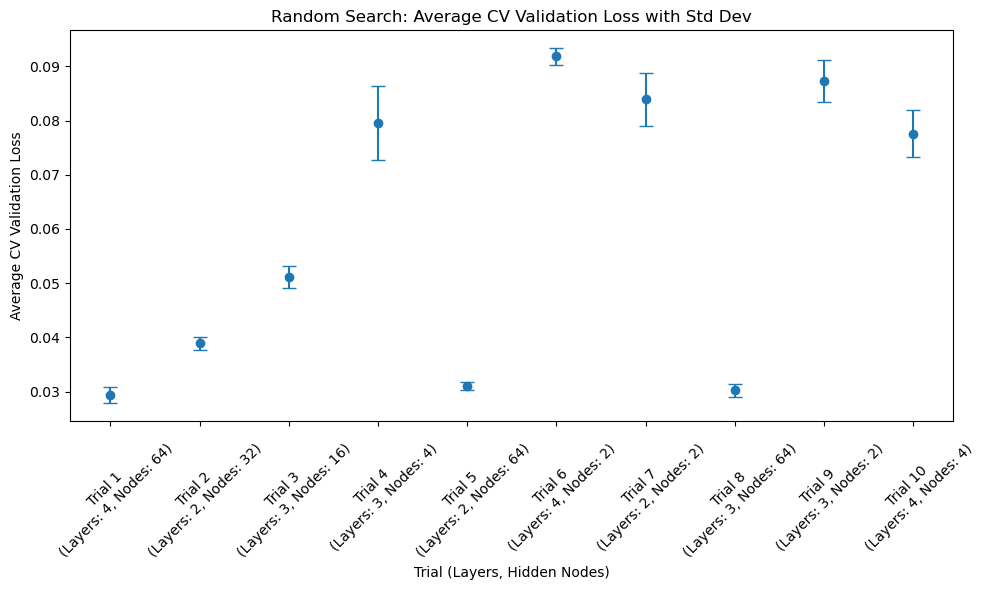

/tmp/ipykernel_391/3656130225.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(fold_losses_data, labels=[f"Trial {i+1}" for i in range(len(df_results))])


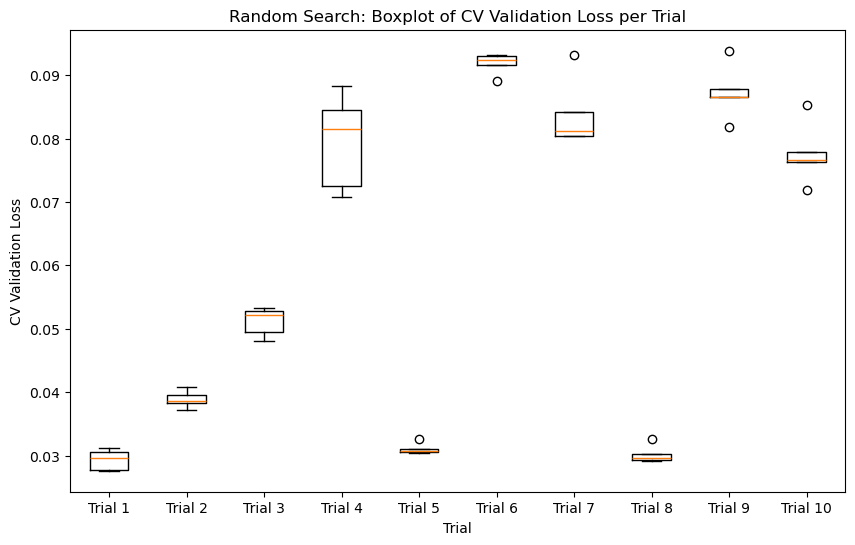

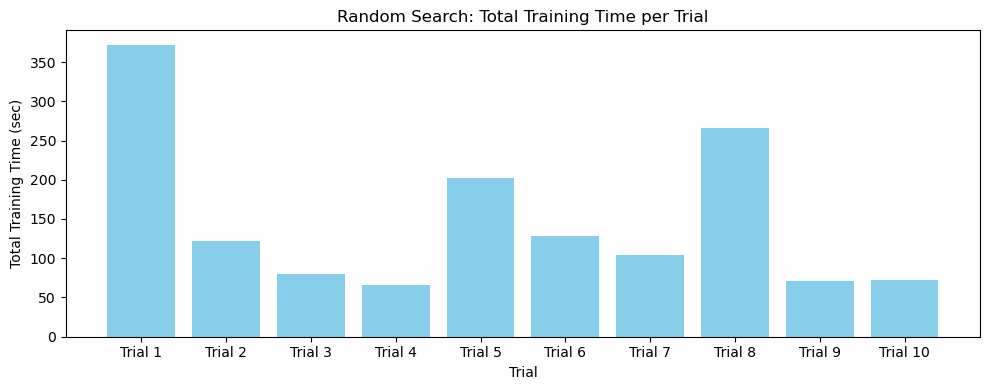

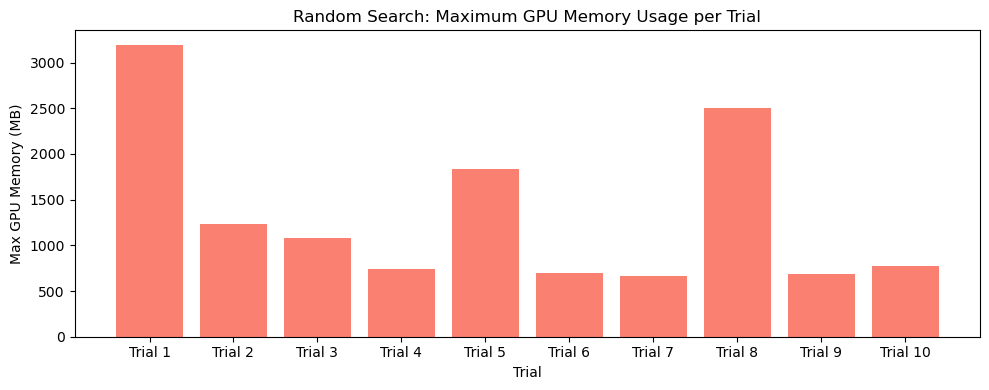

In [12]:
# Convert the random search results to a DataFrame for easier processing
df_results = pd.DataFrame(random_search_results)

# Calculate the standard deviation of the validation loss across folds for each trial
df_results['std_val_loss'] = df_results['fold_losses'].apply(lambda losses: np.std(losses))

# Plot an error bar chart: Trial number (including layers and hidden nodes) vs. Average CV Validation Loss with Standard Deviation
plt.figure(figsize=(10, 6))
x = np.arange(len(df_results))
plt.errorbar(x, df_results['avg_val_loss'], yerr=df_results['std_val_loss'],
             fmt='o', capsize=5)
# Set x-axis labels to show trial number along with corresponding layers and hidden nodes info
plt.xticks(x, [f"Trial {i+1}\n(Layers: {row['layers']}, Nodes: {row['hidden_nodes']})"
               for i, row in df_results.iterrows()], rotation=45)
plt.xlabel("Trial (Layers, Hidden Nodes)")
plt.ylabel("Average CV Validation Loss")
plt.title("Random Search: Average CV Validation Loss with Std Dev")
plt.tight_layout()
plt.show()

# Plot a boxplot: Distribution of CV validation losses for each trial
plt.figure(figsize=(10, 6))
# Extract fold_losses data for each trial
fold_losses_data = df_results['fold_losses'].tolist()
plt.boxplot(fold_losses_data, labels=[f"Trial {i+1}" for i in range(len(df_results))])
plt.xlabel("Trial")
plt.ylabel("CV Validation Loss")
plt.title("Random Search: Boxplot of CV Validation Loss per Trial")
plt.show()

# Bar chart for Total Training Time
plt.figure(figsize=(10, 4))
plt.bar(x, df_results['total_time'], color='skyblue')
plt.xticks(x, [f"Trial {i+1}" for i in range(len(df_results))])
plt.xlabel("Trial")
plt.ylabel("Total Training Time (sec)")
plt.title("Random Search: Total Training Time per Trial")
plt.tight_layout()
plt.show()

# Bar chart for Maximum GPU Memory Usage
plt.figure(figsize=(10, 4))
# Check if max_gpu_mem column exists and is not null (in case GPU is not used)
if 'max_gpu_mem' in df_results.columns and df_results['max_gpu_mem'].notnull().all():
    plt.bar(x, df_results['max_gpu_mem'], color='salmon')
    plt.xticks(x, [f"Trial {i+1}" for i in range(len(df_results))])
    plt.xlabel("Trial")
    plt.ylabel("Max GPU Memory (MB)")
    plt.title("Random Search: Maximum GPU Memory Usage per Trial")
    plt.tight_layout()
    plt.show()
else:
    print("No GPU memory usage data available.")

#### The best parameter for the NN model

Best trial found:
trial                                                             1
layers                                                            4
hidden_nodes                                                     64
avg_val_loss                                               0.029344
fold_losses       [tensor(0.0277), tensor(0.0297), tensor(0.0312...
total_time                                               371.783928
avg_epoch_time                                                    0
max_gpu_mem                                             3193.241699
std_val_loss                                               0.001457
Name: 0, dtype: object


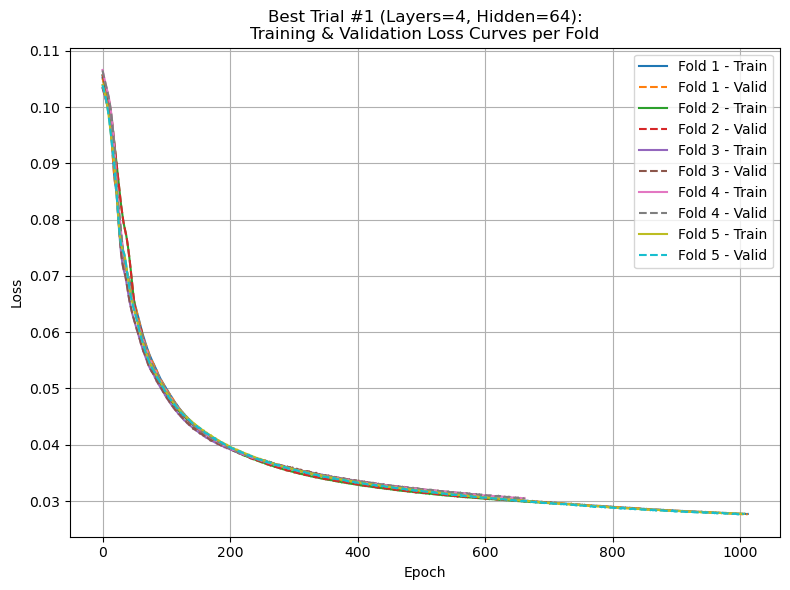

In [13]:
# 1. Find the trial with the lowest validation loss
best_idx = df_results['avg_val_loss'].idxmin()    # Index of the minimum avg_val_loss
best_trial_info = df_results.loc[best_idx]
best_trial_num = best_trial_info['trial']
best_layers = best_trial_info['layers']
best_hid = best_trial_info['hidden_nodes']

print("Best trial found:")
print(best_trial_info)

# 2. Set up the base directory for random search outputs and number of folds
num_folds = 5
# Assume cwd_output is the main directory where outputs are saved
# For example: cwd_output = "/path/to/output"
# The following example follows the same storage logic as in the random search code
base_dir = os.path.join(cwd_output,
    f"random_search_trial_{best_trial_num}_layers_{best_layers}_hidden_{best_hid}"
)

# 3. Plot training and validation loss curves for each fold of the best trial on the same figure
plt.figure(figsize=(8, 6))

for fold in range(1, num_folds+1):
    fold_dir = os.path.join(base_dir, f"fold_{fold}")
    loss_path = os.path.join(fold_dir, 'loss_array.txt')
    
    if not os.path.exists(loss_path):
        print(f"Warning: {loss_path} does not exist, skipping.")
        continue
    
    # Load the loss array for the current fold
    # The typical shape is: [epoch_index, train_loss, val_loss]
    loss_data = np.loadtxt(loss_path)
    
    # If early stopping occurred, different folds may have different number of epochs
    epochs = loss_data[:, 0]
    train_loss = loss_data[:, 1]
    val_loss = loss_data[:, 2]
    
    plt.plot(epochs, train_loss, label=f"Fold {fold} - Train", linestyle='-')
    plt.plot(epochs, val_loss, label=f"Fold {fold} - Valid", linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Best Trial #{best_trial_num} (Layers={best_layers}, Hidden={best_hid}):\n"
          "Training & Validation Loss Curves per Fold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 1.4 Model training

For the self-attention NN model, one second can go through 6.28 epochs, and traning stops at epoch 428 with an early stopping patience of 10. The total training time is 68s with 4028 MB max GPU allocated memory.

On the validation dataset, the model achieves a RMSE of 0.0909.

In [30]:
epochs, k_points, lr=3000, 16, 1e-03

kms1=1.0 #0.1
kms2=1.0 #100.0
kmask=np.array([kms1,kms1,kms2,kms2,kms2,kms2,kms2,kms2,kms2,kms1,kms1,kms1,kms1,kms1,kms1,kms1])

in_nod, hid_nod, o_nod = 4, 64, 16

torch.manual_seed(10)

k_mean_c=torch.tensor(k_mean).float().to(device)
k_std_c=torch.tensor(k_std).float().to(device)

model = learnKappa_layers(in_nod, hid_nod, o_nod)
model = model.to(device)
model, loss_array = modeltrain_loss(in_nod, hid_nod, o_nod, lr, epochs, x, y,valid_x,valid_y,model,torch.tensor(kmask).float().to(device), k_mean_c, k_std_c)

Training Progress:  14%|█▍        | 428/3000 [01:09<06:55,  6.20epoch/s, patience_count=9, train_RMSE=0.0666, train_loss=0.0332, valid_RMSE=0.0917, valid_loss=0.0476]



Early stopping at epoch 428. Validation loss has not improved for 10 epochs.
Total training time (seconds): 69.06630516052246
Average epoch time (seconds): 0.004174333309458795
Maximum GPU memory usage (MB): 4161.6259765625
Final Validation RMSE: 0.09099933505058289


## 1.5 Evaluation and Visualization

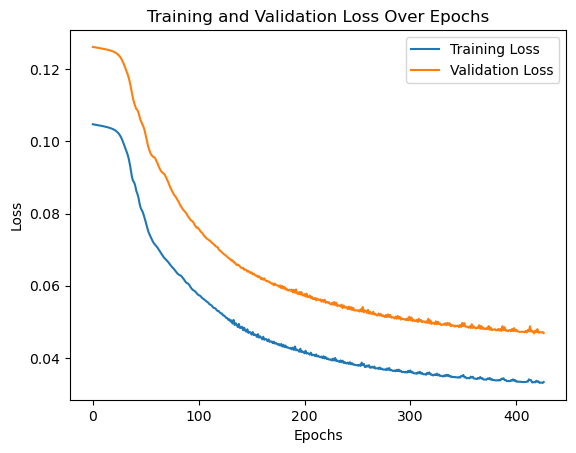

In [31]:
plt.plot(loss_array[:, 0], loss_array[:, 1], label="Training Loss")
plt.plot(loss_array[:, 0], loss_array[:, 2], label="Validation Loss")

# Adding labels and title
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")

# Adding a legend
plt.legend()

# Displaying the plot
plt.show()

Plot saved as 'modelstats.pdf'


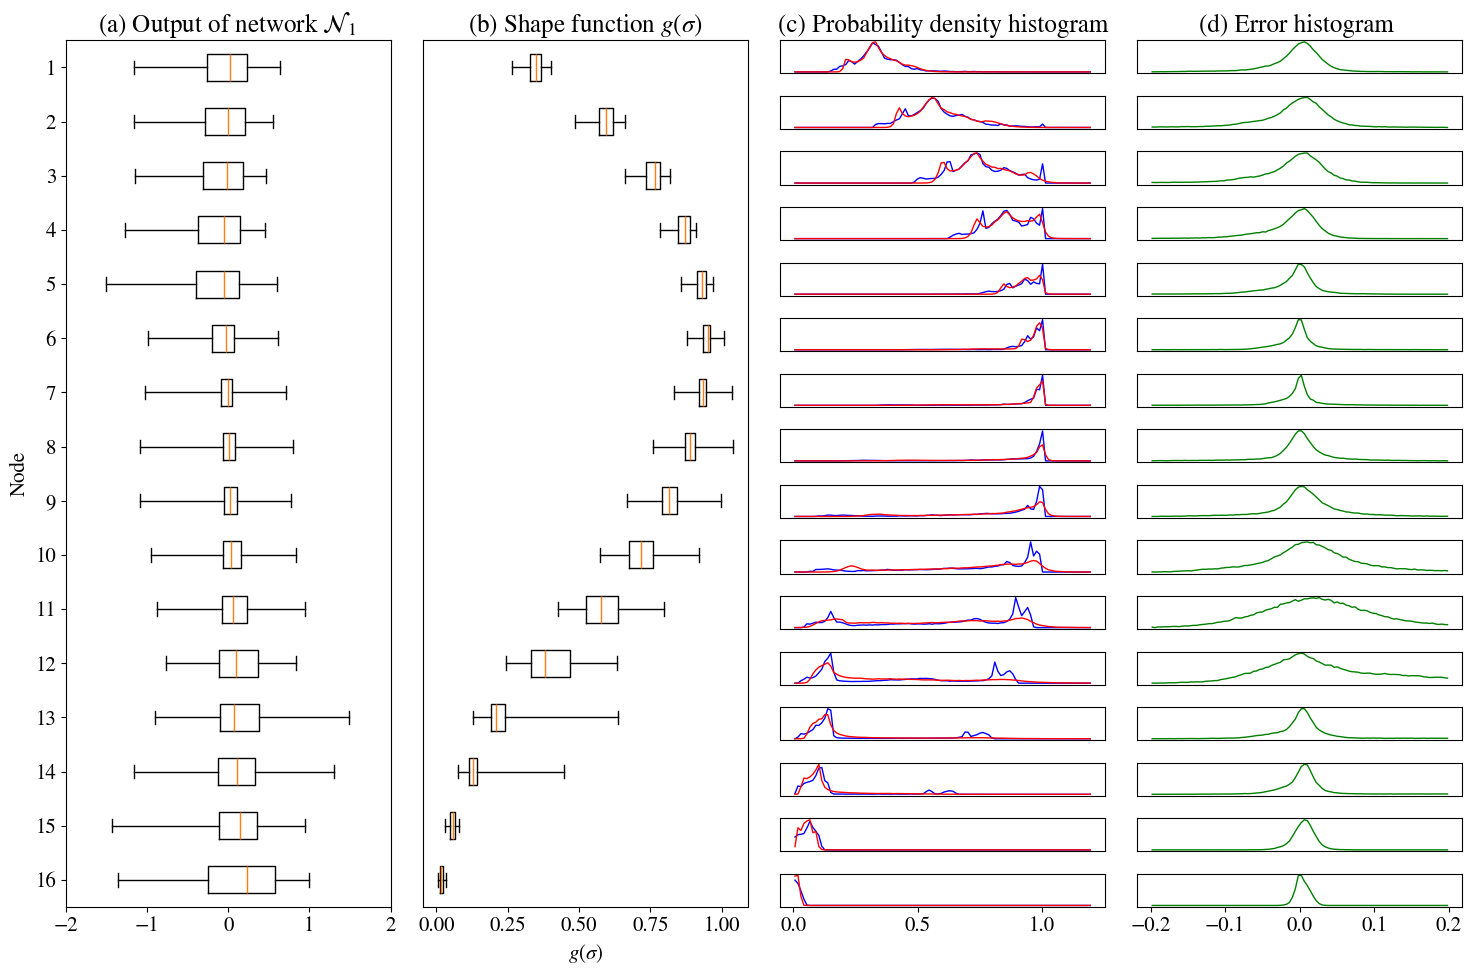

In [32]:
performance_sigma_point(model, x, valid_x, y, valid_y, k_mean, k_std)

Figure (a) illustrates that the self-attention NN’s predicted normalized shape function values are more concentrated, particularly for nodes 1–6, compared to the baseline results. Figure (d) further corroborates this observation, showing that most of the error distributions are centered around zero with a relatively narrow peak width. As seen in Figure (b), the predicted shape function aligns closely with the true values, and the spread of the first eight nodes is minimal. For nodes 10–13, the improvement in prediction accuracy is less pronounced, potentially because the model cannot fully capture the underlying bimodal or multimodal distributions hinted at in Figure (c). Nonetheless, when contrasted with the broader error distributions of the baseline model for nodes 10–12, the self-attention NN achieves a notably tighter error distribution and exhibits reduced overall bias.

Number of nodes for hidden layers might be the key to increase performance of self- attention NN model than number of hidden layers.
The best self-attention NN model has a increase on the performance than the basic one, but the cost of it is high, and the improvement is limited.

# 2. Gaussian Process

Gaussian Process (GP) can learn the probability distribution of the target function and make probabilistic predictions given new inputs. Compared with neural networks, GP inherently model the dependencies between different data points through a covariance function (kernel), and therefore the correlation between the shape function values at different positions can be modeled explicitly using the kernel function. **In this section, we aim to use Gaussian Process Regression (GPR) to predict the shape function values and examine whether accounting for data interdependencies could help increase the prediction accuracy. Following that, we will use SHAP (SHapley Additive exPlanations) analysis to identify the key features that contribute most to the model prediction.**  

## 2.1 Gaussian Process Regression

GP has very high computational complexicity that is proportional to the cube of the sample size O(n^3), making the training process impossible with over 900k samples (the server would explode in one sec). Therefore, we switch to Stochatic Variational Gaussian Process (SVGP) as an approximation of exact GP, which introduces variational inference (approximating intractable posterior distributions) and inducing points (a smaller set of pseudo-inputs to represent the full dataset) to speed up the calculation.

In [10]:
# Define Approximate GP Model (SVGP)
class MultitaskSVGPModel(gpytorch.models.ApproximateGP):
    def __init__(self, num_inducing=500, input_dim=4, num_tasks=16):
        # Using variational inference method
        inducing_points = torch.randn(num_inducing, input_dim)
        
        batch_shape = torch.Size([num_tasks])
        
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )
        
        variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=num_tasks
        )
        
        super(MultitaskSVGPModel, self).__init__(variational_strategy)
        
        # Mean and kernel function
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=batch_shape)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=batch_shape),
            batch_shape=batch_shape
        )
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Early stop when validation loss cease to decrease
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        
    def __call__(self, val_loss, model, likelihood):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model, likelihood)
        else:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                
    def save_checkpoint(self, model, likelihood):
        """Save the model checkpoint."""
        torch.save({
            'model_state_dict': model.state_dict(),
            'likelihood_state_dict': likelihood.state_dict()
        }, self.path)
        print(f'Model checkpoint saved to {self.path}')
        
    def load_checkpoint(self, model, likelihood):
        """Load the best model checkpoint."""
        checkpoint = torch.load(self.path)
        model.load_state_dict(checkpoint['model_state_dict'])
        likelihood.load_state_dict(checkpoint['likelihood_state_dict'])
        return model, likelihood

### Data and model setup

In [11]:
# Load Training Data
X = x  # Shape: (917858, 4)
Y = y  # Shape: (917858, 16)

# Normalize inputs to improve GP performance
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X.cpu().numpy())

# Convert to Torch tensors
X_train = torch.tensor(X_scaled, dtype=torch.float32)
Y_train = torch.tensor(Y, dtype=torch.float32)

# Data Batch Loader Function
def get_batch_loader(X, Y, batch_size=1024, shuffle=True):
    dataset = torch.utils.data.TensorDataset(X, Y)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Prepare validation data
valid_x_scaled = scaler_X.transform(valid_x.cpu().numpy())
valid_x_tensor = torch.tensor(valid_x_scaled, dtype=torch.float32)
valid_y_tensor = torch.tensor(valid_y, dtype=torch.float32)

# Initialize Model
model = MultitaskSVGPModel(num_inducing=500, input_dim=4, num_tasks=16)
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=16)

# Move to GPU
if torch.cuda.is_available():
    model = model.cuda()
    likelihood = likelihood.cuda()
    X_train = X_train.cuda()
    Y_train = Y_train.cuda()
    valid_x_tensor = valid_x_tensor.cuda()
    valid_y_tensor = valid_y_tensor.cuda()
    print("Training on GPU")

/tmp/ipykernel_994/1077069746.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y_train = torch.tensor(Y, dtype=torch.float32)
/tmp/ipykernel_994/1077069746.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_y_tensor = torch.tensor(valid_y, dtype=torch.float32)


Training on GPU


### Functions to save and load trained models

In [12]:
def save_complete_model(model, likelihood, scaler, save_dir="saved_models"):
    """Save the complete model and all necessary components."""
    os.makedirs(save_dir, exist_ok=True)
    
    # Save model and likelihood
    model_state = {
        'model_state_dict': model.state_dict(),
        'likelihood_state_dict': likelihood.state_dict(),
        'model_class': type(model).__name__,
        'model_config': {
            'num_inducing': model.variational_strategy.base_variational_strategy.inducing_points.shape[0],
            'input_dim': model.variational_strategy.base_variational_strategy.inducing_points.shape[1],
            'num_tasks': likelihood.num_tasks
        }
    }
    torch.save(model_state, os.path.join(save_dir, "complete_gp_model.pt"))
    
    # Save data processing components
    with open(os.path.join(save_dir, "scaler.pkl"), "wb") as f:
        pickle.dump(scaler, f)
    
    print(f"Complete model and components saved to {save_dir} directory.")

def load_model_for_prediction(model_dir="saved_models", device="cuda" if torch.cuda.is_available() else "cpu"):
    """Load saved models and related components for prediction."""
    model_state = torch.load(os.path.join(model_dir, "complete_gp_model.pt"), map_location=device)
    model_class = globals()[model_state['model_class']]
    config = model_state['model_config']
    model = model_class(
        num_inducing=config['num_inducing'],
        input_dim=config['input_dim'],
        num_tasks=config['num_tasks']
    )
    
    likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=config['num_tasks'])
    model.load_state_dict(model_state['model_state_dict'])
    likelihood.load_state_dict(model_state['likelihood_state_dict'])
    
    with open(os.path.join(model_dir, "scaler.pkl"), "rb") as f:
        scaler = pickle.load(f)
    
    model = model.to(device)
    likelihood = likelihood.to(device)
    
    model.eval()
    likelihood.eval()
    
    return model, likelihood, scaler

### Training/Loading the trained model

In [14]:
# recommended to use the pre-trained model as training takes a long time; double-check the path if you encounter error when loading the model
train_model = False

if train_model:
    model.train()
    likelihood.train()
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
        {'params': likelihood.parameters()}
    ], lr=0.01)

    # Use the Variational ELBO loss function
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=X_train.size(0))

    # Create data loaders
    train_loader = get_batch_loader(X_train, Y_train, batch_size=1024)
    valid_loader = get_batch_loader(valid_x_tensor, valid_y_tensor, batch_size=1024, shuffle=False)

    # Initialize early stopping
    model_dir = "saved_models"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, "best_gp_model.pt")
    early_stopping = EarlyStopping(patience=10, path=model_path)

    # Initialize variables to track time and memory
    start_time = time.time()
    max_memory_allocated = 0

    # Training loop
    max_epochs = 50
    for epoch in range(max_epochs):
        epoch_start_time = time.time()

        # Training phase
        model.train()
        likelihood.train()
        train_epoch_loss = 0

        for batch_idx, (X_batch, Y_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(X_batch)
            loss = -mll(output, Y_batch)
            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()

            # Update maximum memory allocated
            max_memory_allocated = max(max_memory_allocated, torch.cuda.max_memory_allocated())

            if (batch_idx + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{max_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

        avg_train_loss = train_epoch_loss / len(train_loader)
        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch+1}/{max_epochs}, Avg Training Loss: {avg_train_loss:.4f}, Time: {epoch_time:.2f}s")

        # Validation phase
        model.eval()
        likelihood.eval()
        valid_epoch_loss = 0
        all_preds = [] 
        all_targets = [] 

        with torch.no_grad():
            for X_valid_batch, Y_valid_batch in valid_loader:
                output = model(X_valid_batch)
                loss = -mll(output, Y_valid_batch)
                valid_epoch_loss += loss.item()

        avg_valid_loss = valid_epoch_loss / len(valid_loader)
        print(f"Epoch {epoch+1}/{max_epochs}, Validation Loss: {avg_valid_loss:.4f}")

        # Check early stopping condition
        early_stopping(avg_valid_loss, model, likelihood)
        if early_stopping.early_stop:
            print("Early stopping triggered, stopping training!")
            break

    # Load the best model
    model, likelihood = early_stopping.load_checkpoint(model, likelihood)

    # Print total training time and maximum memory usage
    total_time = time.time() - start_time
    print(f"Total Training Time: {total_time:.2f}s")
    print(f"Max GPU Memory Allocated: {max_memory_allocated / 1024 ** 2:.2f} MB")
    
else:
    model, likelihood, scaler = load_model_for_prediction()

### Statistics

For the SVGP model, each epoch of batch training takes 175s, and traning stops at epoch 12 with an early stopping patience of 10.   **The total training time is 2139s (35.6 min) with 728 MB max GPU allocated memory.**  

On the validation dataset, the model achieves a RMSE of 0.0847.

In [23]:
model.eval()
likelihood.eval()

valid_x_tensor = valid_x.clone().detach().float()
valid_y_tensor = valid_y.clone().detach().float()
valid_loader = get_batch_loader(valid_x_tensor, valid_y_tensor, batch_size=1024, shuffle=False)

all_preds = [] 
all_targets = []  

with torch.no_grad():
    for X_valid_batch, Y_valid_batch in valid_loader:
        output = model(X_valid_batch) 
        preds = output.mean  # GP mean predictions
        
        all_preds.append(preds.cpu())
        all_targets.append(Y_valid_batch.cpu())

# Concatenate all batches
all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# **Denormalize predictions and targets safely**
all_preds_denorm = np.exp(all_preds.numpy() * k_std + k_mean)
all_targets_denorm = np.exp(all_targets.numpy() * k_std + k_mean)

# Compute RMSE in the original scale
mse = np.mean((all_preds_denorm - all_targets_denorm) ** 2)
rmse = np.sqrt(mse)

print(f"Denormalized RMSE: {rmse:.4f}")

Denormalized RMSE: 0.0847


### Predictions

**The GPR predictions are superior to that of neural networks as a whole.** Figure (a) indicates that GPR-predicted normalized shape function values is more concentrated, especially for nodes 1~6 when comparing to neural networks. Figure (d) further confirms that most error distributions centers around 0 with a small peak width. The shape function in Figure (b) intuitively show that predicted values highly aligns with true values, and the spread of the first 8 nodes is minimal. For nodes 10-13, the improvement on prediction accuracy is insignificant, possibly due to the model's inability to fully capture the bimodal/multi-modal probability distribution as indicated in Figure (c). However, comparing to the wide error distribution of nodes 10-12 for neural networks, GBR predictions achieves much tighter error distribution with reduced overall bias.

Plot saved as 'modelstats.pdf'


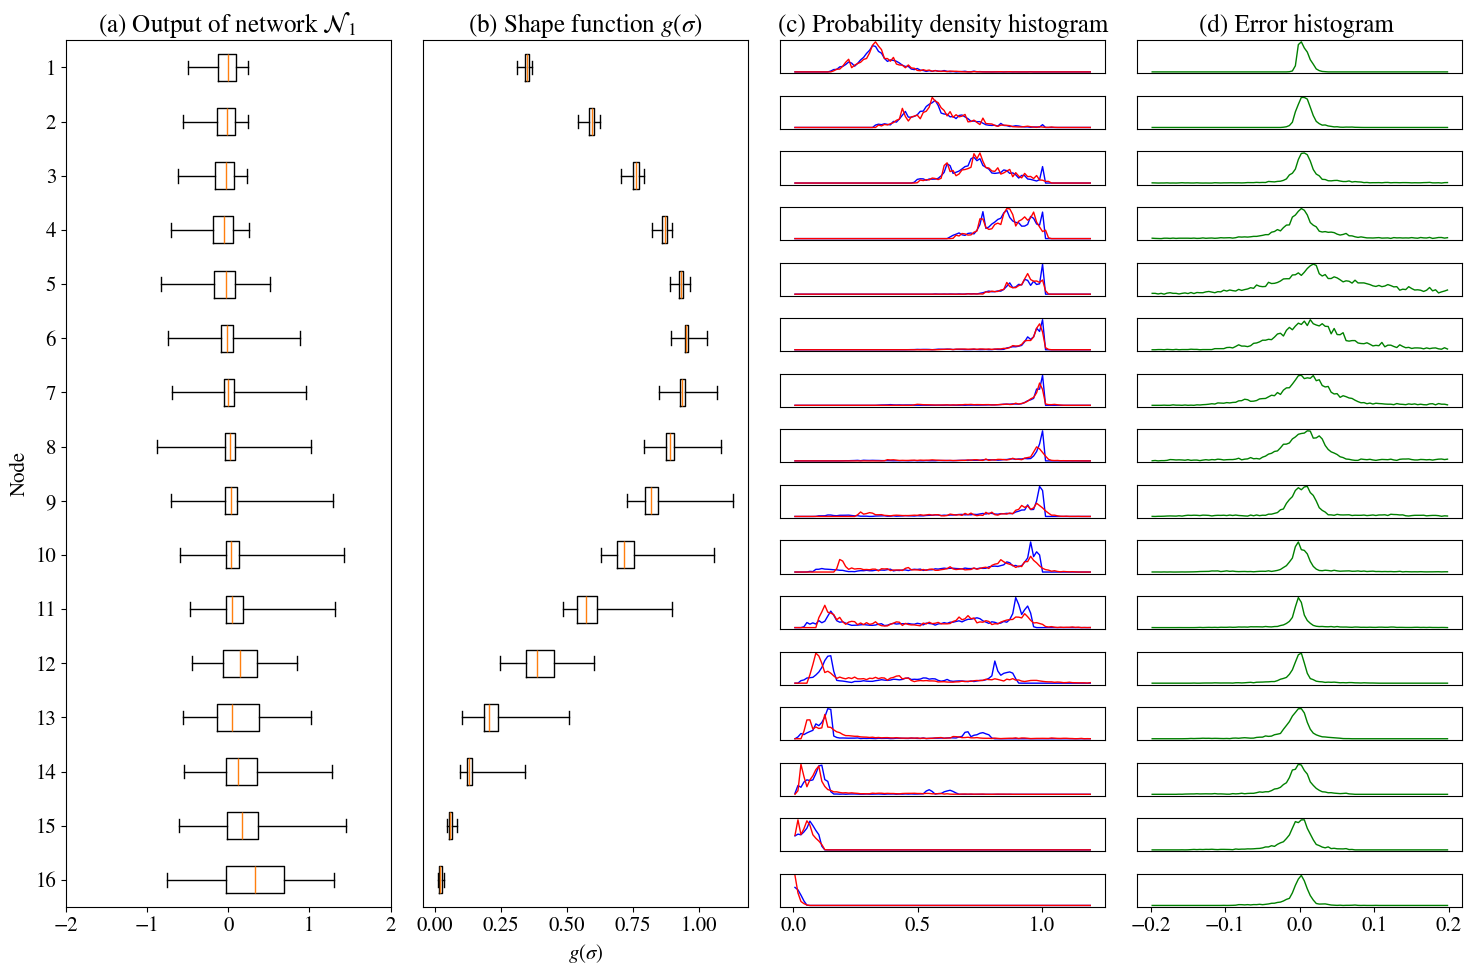

In [15]:
# Function performance_sigma_point_batched was added to visual_figure4.py and imported in section 0
performance_sigma_point_batched(model, x, valid_x, y, valid_y, k_mean, k_std)

## 2.2 SHAP Analysis

SHAP (SHapley Additive exPlanations) is an explainability technique for interpreting machine learning models. It is based on game theory and provides a way to fairly attribute the contribution of each feature to the model’s prediction. Specifically, it assigns feature importance by calculating the marginal contribution of different feature combinations to the model output.

In [16]:
# Prepare test data
X_test = valid_x.cpu().numpy()
X_test_scaled = scaler_X.transform(X_test)

As SHAP values are computed for each sample, the size of the validation dataset (~900k samples) makes it impossible to do calculations over the full dataset. Here, we first use K-means clustering to select 100 representative samples as background dataset, and then randomly select 1000 samples to calculate SHAP values and identify feature importance.

In [17]:
# Define a wrapper function to get predictions
def gp_model_predict_single_output(X, output_index):
    X_torch = torch.tensor(X, dtype=torch.float32).to(next(model.parameters()).device)
    with torch.no_grad():
        preds = likelihood(model(X_torch))  # GP prediction
    return preds.mean[:, output_index].cpu().numpy()  # Extract one output dimension

shap_values_list = []
np.random.seed(42)

for output_index in range(16):
    print(f"Computing SHAP values for output {output_index+1}/16")
    # K-means to select 100 representatives as background
    X_sample = shap.kmeans(X_test_scaled, 100)
    explainer = shap.KernelExplainer(lambda x: gp_model_predict_single_output(x, output_index), X_sample)
    
    # Randomly get 1000 samples for testing
    X_explained = shap.sample(X_test_scaled, 1000)
    shap_values = explainer.shap_values(X_explained)  
    shap_values_list.append(shap_values)

Computing SHAP values for output 1/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 2/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 3/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 4/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 5/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 6/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 7/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 8/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 9/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 10/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 11/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 12/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 13/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 14/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 15/16


  0%|          | 0/1000 [00:00<?, ?it/s]

Computing SHAP values for output 16/16


  0%|          | 0/1000 [00:00<?, ?it/s]

### SHAP Summary Plots

SHAP summary plots provide insights into how different features (I0, b00, h0, ustar0) impact the model’s predictions. These plots are arranged based on following principles:  
1. Feature Importance: The features are sorted by importance, with **the most impactful feature appearing at the top**;
2. SHAP Values: The X-axis represents SHAP values, which measure the magnitude and direction of a feature’s effect on the model’s prediction (**positive SHAP values indicate that the feature increases the model's output and vice versa**);
3. Feature Values: The color gradient (blue to red) represents the feature values, which are raw input to the model (e.g., actual h0 value). **Blue = low feature values, Red = high feature values**.

From the SHAP summary plots shown below, several patterns could be observed:  
1. The SHAP values for different features generally have wide spreads, indicating the influence varies significantly across different samples.
2. **For the first 11 locations, Coriolis force (I0) is the most influential feature, followed by Surface buoyancy flux (b00).** Low I0 values tend to decrease the prediction while high I0 values tend to increase it. As depth increases, the distribution of I0 SHAP values becomes more skewed as the contribution of high I0 values becomes more insignificant and gradually centers around 0. At the same time, low I0 values consistently show strong negative effects on model predictions.
3. **For the last 5 locations, Surface buoyancy flux (b00) becomes the most significant feature.** The influence of b00 is highly nonlinear, with low values increasing model output, middle values having negligible effects and high values decreasing model output.

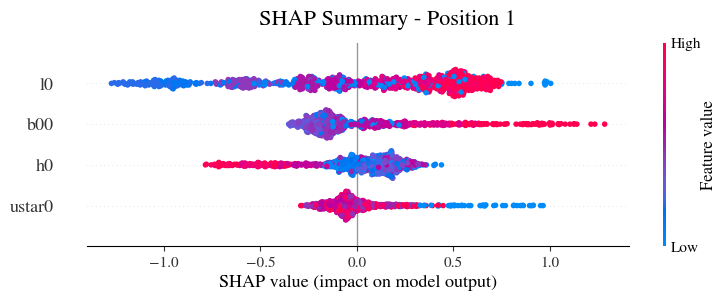

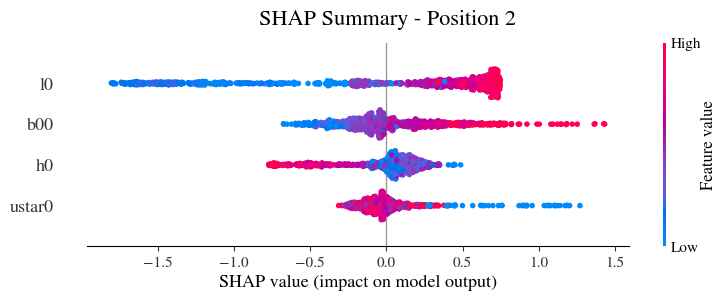

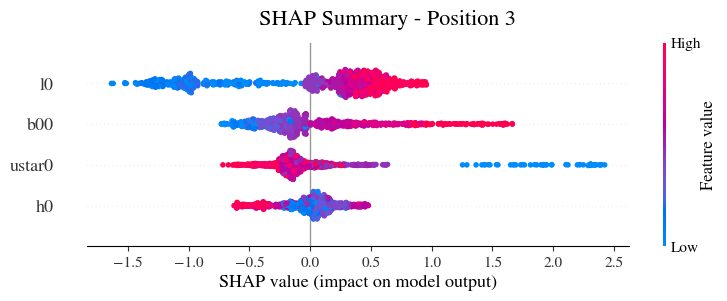

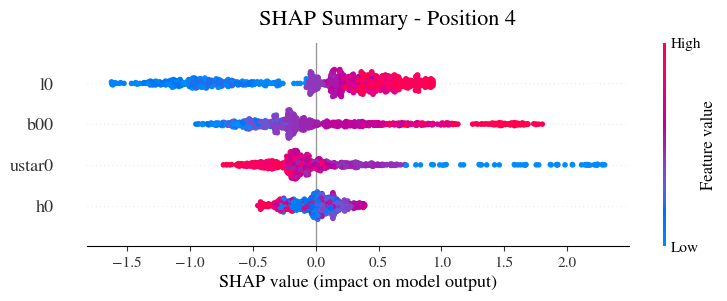

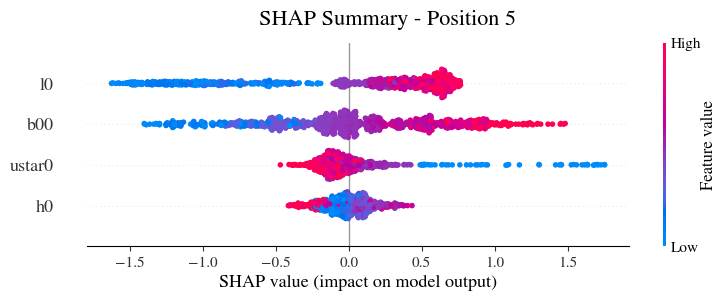

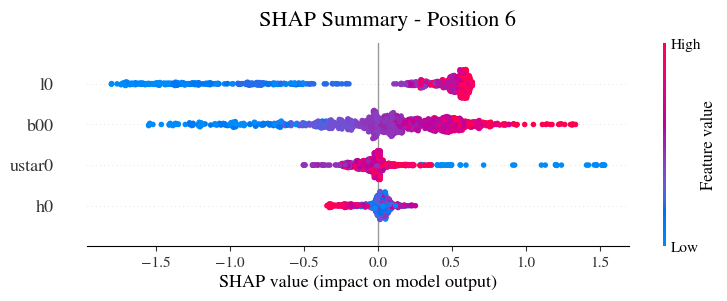

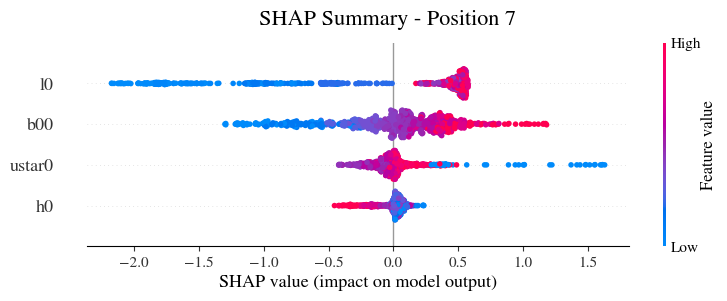

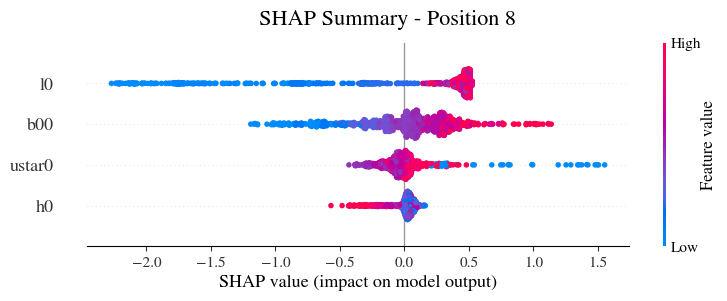

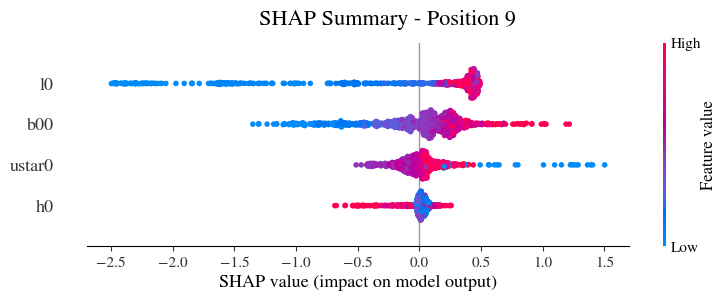

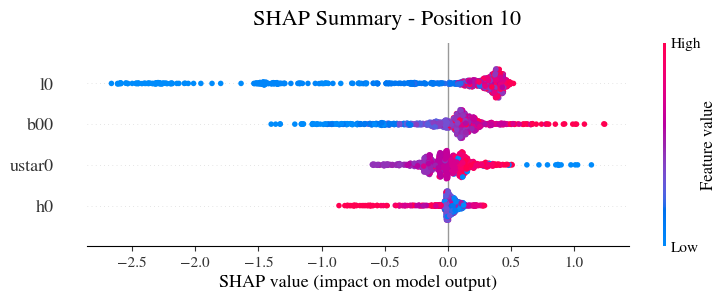

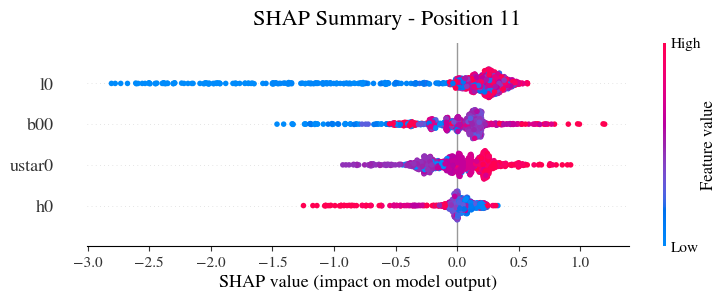

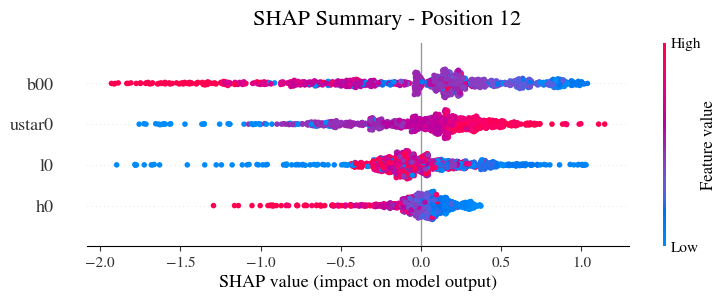

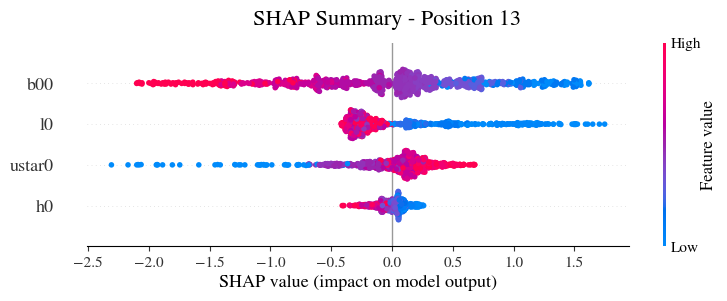

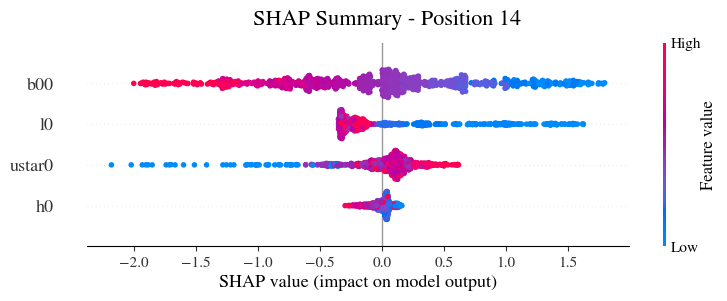

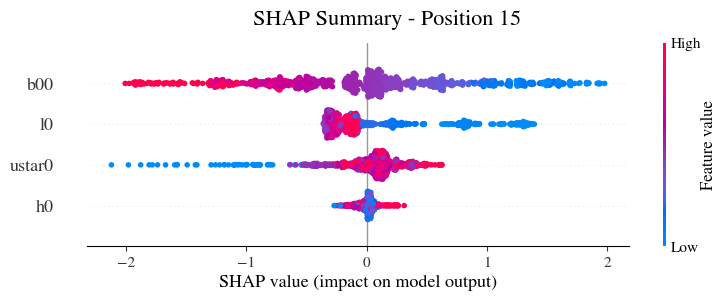

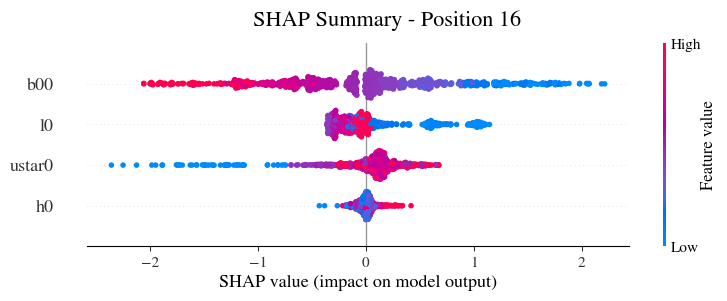

In [18]:
num_positions = 16
interval = 1
selected_indices = list(range(0, num_positions, interval))

for idx in selected_indices:
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_list[idx], X_explained, feature_names=['l0', 'b00', 'ustar0', 'h0'], show=False )
    plt.gcf().suptitle(f"SHAP Summary - Position {idx + 1}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 1.1])
    plt.show()
    plt.close()

### Feature Importance Map

**The absolute values of SHAP values reflects the magnitude of influence for different features.** It can be seen from the map below that Coriolis force (I0) dominates the prediction for the upper ocean (first 11 locations) while Surface buoyancy flux (b00) plays a more important role for lower-level ocean shape function values. 

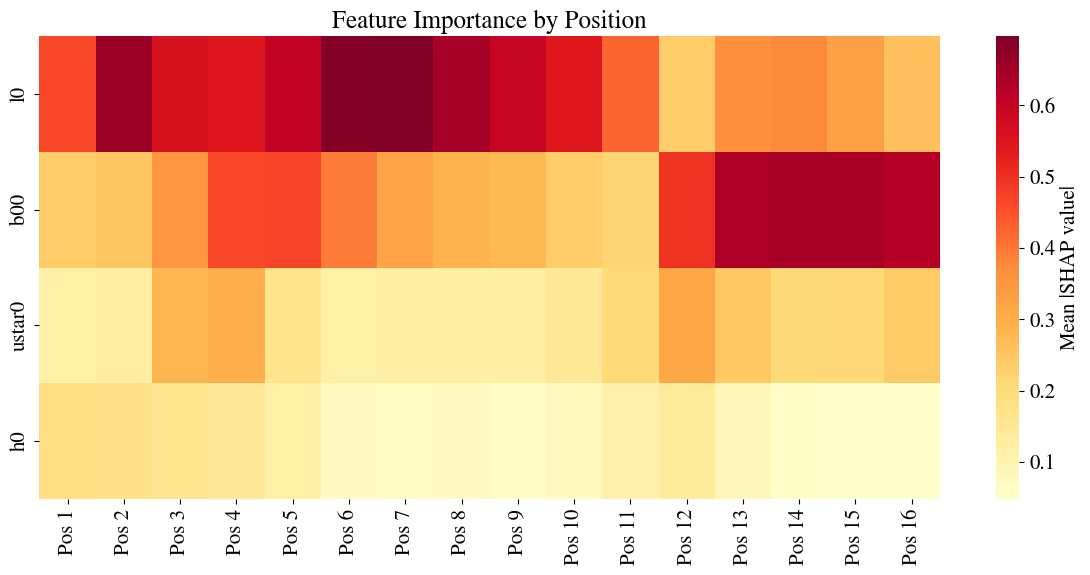

In [20]:
# Calculate average absolute SHAP value for each feature across all positions
feature_names = ['l0', 'b00', 'ustar0', 'h0']
all_importances = np.zeros((len(shap_values_list), len(feature_names)))

for i, shap_values in enumerate(shap_values_list):
    all_importances[i] = np.abs(shap_values).mean(axis=0)

# Feature Importance Heatmap
plt.figure(figsize=(12, 6))

# Create a heatmap
sns.heatmap(
    all_importances.T,  # Transpose for better visualization
    cmap="YlOrRd",
    yticklabels=feature_names,
    xticklabels=[f"Pos {i+1}" for i in range(all_importances.shape[0])],
    cbar_kws={'label': 'Mean |SHAP value|'}
)

plt.title("Feature Importance by Position")
plt.tight_layout()
plt.show()
plt.close()

### Global Feature Importance

Averaging across 16 locations, Coriolis force (I0) is the most influential feature, followed by Surface buoyancy flux (b00). Surface friction velocity (ustar0) also impact predictions, while boundary layer depth (h0) has the least effect.

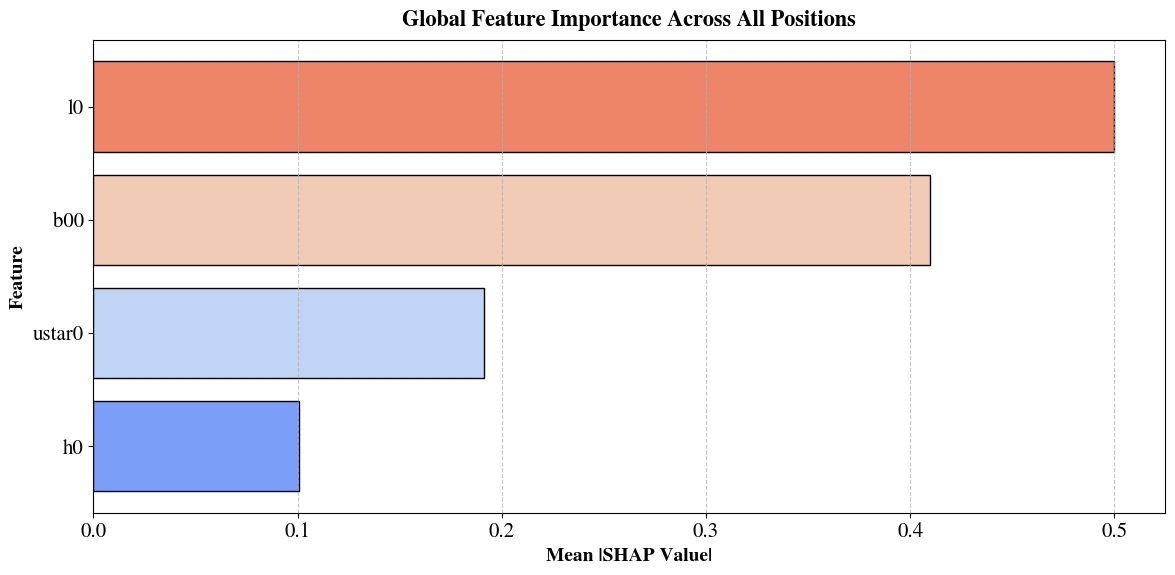

In [21]:
# Average across all positions
avg_importance = all_importances.mean(axis=0)

colors = sns.color_palette("coolwarm_r", len(avg_importance))
plt.figure(figsize=(12, 6))
bars = plt.barh(feature_names, avg_importance, color=colors, edgecolor="black")
plt.xlabel("Mean |SHAP Value|", fontsize=14, fontweight="bold")
plt.ylabel("Feature", fontsize=14, fontweight="bold")
plt.title("Global Feature Importance Across All Positions", fontsize=16, fontweight="bold", pad=10)
plt.gca().invert_yaxis() 
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Above results show that accounting for data interdependencies by adopting Gaussian process greatly increases shape function prediction accuracy, and adding SHAP analysis after ML models helps further identify feature interactions and importance. Such combined approach offers enhanced accuracy and explanability over pure black-box ML models.  

However, the computational complexity makes it impossible to carry out exact GP process, and SHAP values cannot be calculated for the whole dataset. In addition, SHAP results have shown large spread for different features, making it difficult to draw consistent conclusions and imposing constraints on the acquired explanability. 

# 3. Symbolic Regression

**Symbolic Regression** is a machine learning method that discovers mathematical expressions that best describe a given dataset. Whereas neural networks rely on an uninterpretable series of computations—often referred to as a "black box"—symbolic regression produces a set of equations of increasing complexity that are readable and interpretable by humans. However, this interpretability comes at increased computational cost. Models take significantly longer to run as the method searches through a vast space of possible equations, making it less scalable for high-dimensional or large datasets.


In this project we are utilizing **PySR (Python Symbolic Regression)**, an open-source package designed by Miles Cramner for efficient symbolic regression. For more information refer to *Cranmer 2023*:

*Cranmer, M. (2023). Interpretable machine learning for science with PySR and SymbolicRegression. jl. arXiv preprint arXiv:2305.01582*.


## 3.1 Model 1: Normalized Inputs

In our first attempt, we modeled the set up of the initial neural network from *Sane et al. (2023)* with the four input physical parameters ($ \mathcal{N}_1 $.) to predict $ g(\sigma) $ at 16 depth parameters. The resulting model produces 16 separate equations of varying complexity, each corresponding to one of the original 16 depth nodes.

PySR allows users to define both simple binary and complex unary operators. However, incorporating additional operators significantly increases computation time. To minimize lengthy model runs while still selecting unary operators, we performed symbolic regression on a subset of grid cells using a predefined set of operators: 'square,' 'exp,' 'sin,' 'cos,' 'neg,' 'sqrt,' and 'log.' Based on the performance of the models, we selected 'square' and 'sin' for all of our final models, as these operators were most commonly used in the best-performing equations.

In [11]:
## convert tensor object back to numpy array 

x = x.cpu().numpy()
y = y.cpu().numpy()

valid_x = valid_x.cpu().numpy()
valid_y = valid_y.cpu().numpy()

In [29]:
# Define the output directory
output_dir = "/home/jovyan/ML_Project2_Team1/pysrmods"

cwd_pysrout = cwd + '/pysrout/'

print(cwd_pysrout)

/home/jovyan/ML_Project2_Team1/pysrout/


In [13]:
## model set up

default_pysr_params = dict(
    populations=30,  # default
    model_selection="best", ## 'best' selects the candidate model with the highest score among expressions with a loss better than at least 1.5x the most accurate model. 
)

# Create the PySRRegressor model with output directory
model = PySRRegressor(
    niterations=30,  # Reduced from 100 for computation time  
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["square", "sin"], 
    **default_pysr_params,
    batching=True,  # Enable batching  
    batch_size=64,
    verbosity=0,  # Suppress output - this can bog down the notebook
    output_directory=cwd_pysrout,  # Set output directory here
)


In [14]:
# NOTE : we have commented this out as running the model can take a long time
## in the next cell we are going to load a previous model
#model.fit(x, y) 

/srv/conda/envs/notebook/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


PySRRegressor.equations_ = [
[
	    pick     score                                           equation  \
	0         0.000000                                       2.4957185e-6   
	1         0.046815                                    x0 * 0.29490986   
	2         0.046712                                sin(x0) / 2.0314455   
	3         0.046115                               sin(square(x0)) / x0   
	4   >>>>  0.092479                         sin(x0 / (x0 + 1.2237585))   
	5         0.001823                    sin(sin(x0 / (x0 + 1.2287738)))   
	6         0.007552          sin(x0 / ((x0 + 2.7642353) * 0.59714323))   
	7         0.004747    sin(((x0 / 1.2237585) + x0) / (x0 + 2.7530184))   
	8         0.000842   (sin(x0 + x0) + sin(x1 - 0.6757509)) * 0.6805366   
	9         0.000511  sin(((square(square(x0)) / x0) - (-0.3807395 *...   
	10        0.003490  sin(((0.5863865 * square(square(x0))) / x0) - ...   
	11        0.031952  sin(sin(square(x0) - -0.15043259) * (x0 - ((x1...   
	12        0.004515  sin(((0.53195274 / x0) * square(square(x0))) -...   
	
	        loss  complexity  
	0   1.000000           1  
	1   0.910619           3  
	2   0.869060           4  
	3   0.829894           5  
	4   0.756588           6  
	5   0.755210           7  
	6   0.749528           8  
	7   0.742447          10  
	8   0.741822          11  
	9   0.741443          12  
	10  0.738860          13  
	11  0.715625          14  
	12  0.712401          15  
], [
	    pick     score                                           equation  \
	0         0.000000                                       0.0001632276   
	1   >>>>  0.351314                                            sin(x0)   
	2         0.024784                                       sin(sin(x0))   
	3         0.015601                                sin(x0) * 0.7661646   
	4         0.118419                                  sin(x0 + sin(x1))   
	5         0.039220                       sin(x0 - (x1 * -0.52618647))   
	6         0.002454                     sin(x0 + sin(x1 * 0.68072957))   
	7         0.006332          sin(x0 + ((x1 * 0.5021644) - 0.07569894))   
	8         0.002635      sin(x0 + sin((x1 * 0.68072957) - 0.13215078))   
	9         0.069873  sin((x1 + (1.44413 - square(0.8666958 - x0))) ...   
	10        0.001464  sin(((1.44413 - square(x0 - 0.8666958)) + x1) ...   
	11        0.004989  sin(((x0 + (x1 - -0.6494128)) - square(0.43475...   
	12        0.008338  sin(((x0 + (x1 - -1.2015238)) - square(0.56358...   
	13        0.001733  sin((((0.34874505 - (x0 / -0.5323164)) - (x0 *...   
	
	        loss  complexity  
	0   1.000000           1  
	1   0.703763           2  
	2   0.686535           3  
	3   0.675908           4  
	4   0.600425           5  
	5   0.577332           6  
	6   0.575917           7  
	7   0.572282           8  
	8   0.570776           9  
	9   0.496335          11  
	10  0.495609          12  
	11  0.493143          13  
	12  0.484987          15  
	13  0.477482          24  
], [
	    pick     score                                           equation  \
	0         0.000000                                        3.941425e-9   
	1         0.156758                                            sin(x1)   
	2         0.053072                                      x1 * 0.431602   
	3         0.006168                                sin(x1 * 0.5738731)   
	4   >>>>  0.240733                              (x0 + x1) * 0.4203793   
	5         0.012032                         sin((x0 + x1) * 0.5180357)   
	6         0.118479                      ((x0 + x1) - x2) * 0.37846044   
	7         0.006484      (x1 + (x0 + (x2 * -0.62966394))) * 0.45436603   
	8         0.122602  (((x0 - 0.97124016) + x1) + square(x2)) / 2.98...   
	9         0.000095  ((x0 - sin(1.4965949)) + (x1 + square(x2))) / ...   
	10        0.023073  (((x0 + x1) * 2.5939388) - (1.3762853 - square...   
	11        0.019276  ((x1 + (x0 - -1.9357764)) * 0.41916654) - sin(...   
	12        0.001600  (((x1 + (0.107

In [23]:
# Define the run_directory. 
#ML_Project2_Team1/pysrout/20250325_025749_EpCfJx

run_directory = cwd_pysrout + "/20250325_025749_EpCfJx" ## this file extention refers to the most recent model. 

print(run_directory)

# Load model from the checkpoint - this can be finnicky, double check your file paths if you recieve an error
model = PySRRegressor.from_file(run_directory=run_directory)

Attempting to load model from /home/jovyan/ML_Project2_Team1/pysrout/20250325_025749_EpCfJx/checkpoint.pkl...


/home/jovyan/ML_Project2_Team1/pysrout//20250325_025749_EpCfJx


In [24]:
## look at all equations for every depth
print(model)

PySRRegressor.equations_ = [
[
	    pick     score                                           equation  \
	0         0.000000                                       2.4957185e-6   
	1         0.046815                                    x0 * 0.29490986   
	2         0.046712                                sin(x0) / 2.0314455   
	3         0.046115                               sin(square(x0)) / x0   
	4   >>>>  0.092479                         sin(x0 / (x0 + 1.2237585))   
	5         0.001823                    sin(sin(x0 / (x0 + 1.2287738)))   
	6         0.007552          sin(x0 / ((x0 + 2.7642353) * 0.59714323))   
	7         0.004747    sin(((x0 / 1.2237585) + x0) / (x0 + 2.7530184))   
	8         0.000842   (sin(x0 + x0) + sin(x1 - 0.6757509)) * 0.6805366   
	9         0.000511  sin(((square(square(x0)) / x0) - (-0.3807395 *...   
	10        0.003490  sin(((0.5863865 * square(square(x0))) / x0) - ...   
	11        0.031952  sin(sin(square(x0) - -0.15043259) * (x0 - ((x1...   
	12    

### 3.1.1 Model 1: Figures

In [16]:
## redefine the plotting code from Sane et al. so that it can use the pysr predict function
def get_hist(y, k_mean, k_std):
    """Get histogram values for normalized data."""
    vals, binss = np.histogram(np.exp(y * k_std + k_mean), range=(0, 1.2), bins=100)
    return vals, 0.5 * (binss[0:-1] + binss[1:])

def get_hist2(y):
    """Get histogram values for error data."""
    vals, binss = np.histogram(y, range=(-0.2, 0.2), bins=100)
    return vals, 0.5 * (binss[0:-1] + binss[1:])

def performance_sigma_point2(model, x, valid_x, y, valid_y, k_mean, k_std):
    """Plot the performance of a neural network model.

    Parameters:
        model: Trained neural network model.
        x: Training input data.
        valid_x: Validation input data.
        y: Training output data (NumPy array).
        valid_y: Validation output data (NumPy array).
        k_mean: Mean normalization values.
        k_std: Standard deviation normalization values.
    """
    # plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['font.size'] = 15
    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['legend.fontsize'] = 8
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['mathtext.fontset'] = 'stix'  # ensures it can math compatibility with symbols in your code without erroring fix no cursive_fontsystem

    y_pred_train = model.predict(x)
    y_pred_test = model.predict(valid_x)

    # Since y, valid_y, y_pred_train, and y_pred_test are NumPy arrays, no need for .cpu() or .detach()
    ycpu = y
    ytestcpu = valid_y
    yptraincpu = y_pred_train
    yptestcpu = y_pred_test

    ystd = np.zeros(16)
    yteststd = np.zeros(16)
    ypstd = np.zeros(16)
    ypteststd = np.zeros(16)
    yerr = np.zeros(16)
    kappa_mean = np.zeros(16)

    for i in range(16):
        ystd[i] = np.std(np.exp(ycpu[:, i] * k_std[i] + k_mean[i]))
        yteststd[i] = np.std(np.exp(ytestcpu[:, i] * k_std[i] + k_mean[i]))
        ypstd[i] = np.std(np.exp(yptraincpu[:, i] * k_std[i] + k_mean[i]))
        ypteststd[i] = np.std(np.exp(yptestcpu[:, i] * k_std[i] + k_mean[i]))
        yerr[i] = np.std(np.exp(ytestcpu[:, i] * k_std[i] + k_mean[i]) - np.exp(yptestcpu[:, i] * k_std[i] + k_mean[i]))

        kappa_mean[i] = np.mean(np.exp(ycpu[:, i] * k_std[i] + k_mean[i]))

    plt.figure(figsize=(15, 10))

    ind = np.arange(0, 16)
    ind_tick = np.arange(1, 17)[::-1]

    # Subplot 1: Boxplot of network output differences
    plt.subplot(1, 4, 1)
    for i in range(16):
        plt.boxplot(ytestcpu[:, i] - yptestcpu[:, i], vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
    plt.xlim([-2.0, 2.0])
    plt.yticks(ind, ind_tick)
    plt.title(r'(a) Output of network $\mathcal{N}_1$ ')
    plt.ylabel('Node')

    # Subplot 2: Boxplot of shape function differences
    plt.subplot(1, 4, 2)
    for i in range(16):
        plt.boxplot(kappa_mean[i] + np.exp(ytestcpu[:, i] * k_std[i] + k_mean[i]) - np.exp(yptestcpu[:, i] * k_std[i] + k_mean[i]),
                    vert=False, positions=[i], showfliers=False, whis=(5, 95), widths=0.5)
    plt.yticks([])
    plt.title(r'(b) Shape function $g(\sigma)$')
    plt.xlabel(r'$g(\sigma)$')

    # Subplots 3 & 4: Histograms
    k12 = 15
    for k in range(16):
        plt.subplot(16, 4, 4 * k + 3)
        vals, binss = get_hist(ytestcpu[:, k12], k_mean[k12], k_std[k12])
        plt.plot(binss, vals, color='blue')

        vals, binss = get_hist(yptestcpu[:, k12], k_mean[k12], k_std[k12])
        plt.plot(binss, vals, color='red')
        if k < 15:
            plt.xticks([])
        plt.yticks([])
        if k == 0:
            plt.title('(c) Probability density histogram')

        plt.subplot(16, 4, 4 * k + 4)
        vals, binss = get_hist2(np.exp(ytestcpu[:, k12] * k_std[k12] + k_mean[k12]) - np.exp(yptestcpu[:, k12] * k_std[k12] + k_mean[k12]))
        plt.plot(binss, vals, color='green')
        if k < 15:
            plt.xticks([])
        plt.yticks([])
        if k == 0:
            plt.title('(d) Error histogram ')

        k12 -= 1

    plt.tight_layout()
    # print("Plot saved as 'modelstats.pdf'")



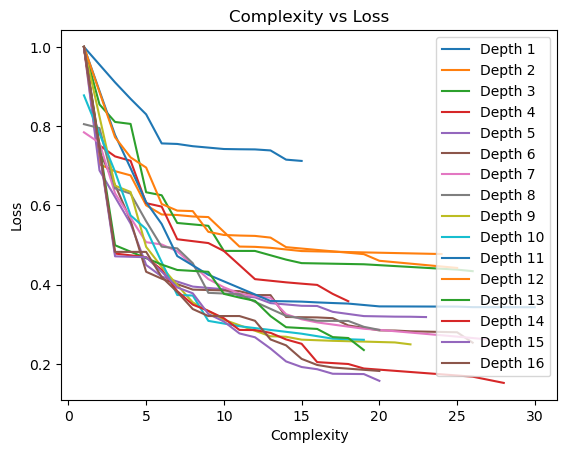

In [17]:
## complexity versus loss plots

# Loop through each depth in model.equations_
for i in range(len(model.equations_)):
    depth1 = model.equations_[i]  # Extract the current depth's data

    # Extract the values for complexity and loss
    complexity_values = depth1['complexity']
    loss_values = depth1['loss']

    # Create a line plot
    plt.plot(complexity_values, loss_values, label=f'Depth {i+1}')

# Labels and title
plt.xlabel('Complexity')
plt.ylabel('Loss')
plt.title('Complexity vs Loss')

# Add legend
plt.legend()

# Show plot
plt.show()


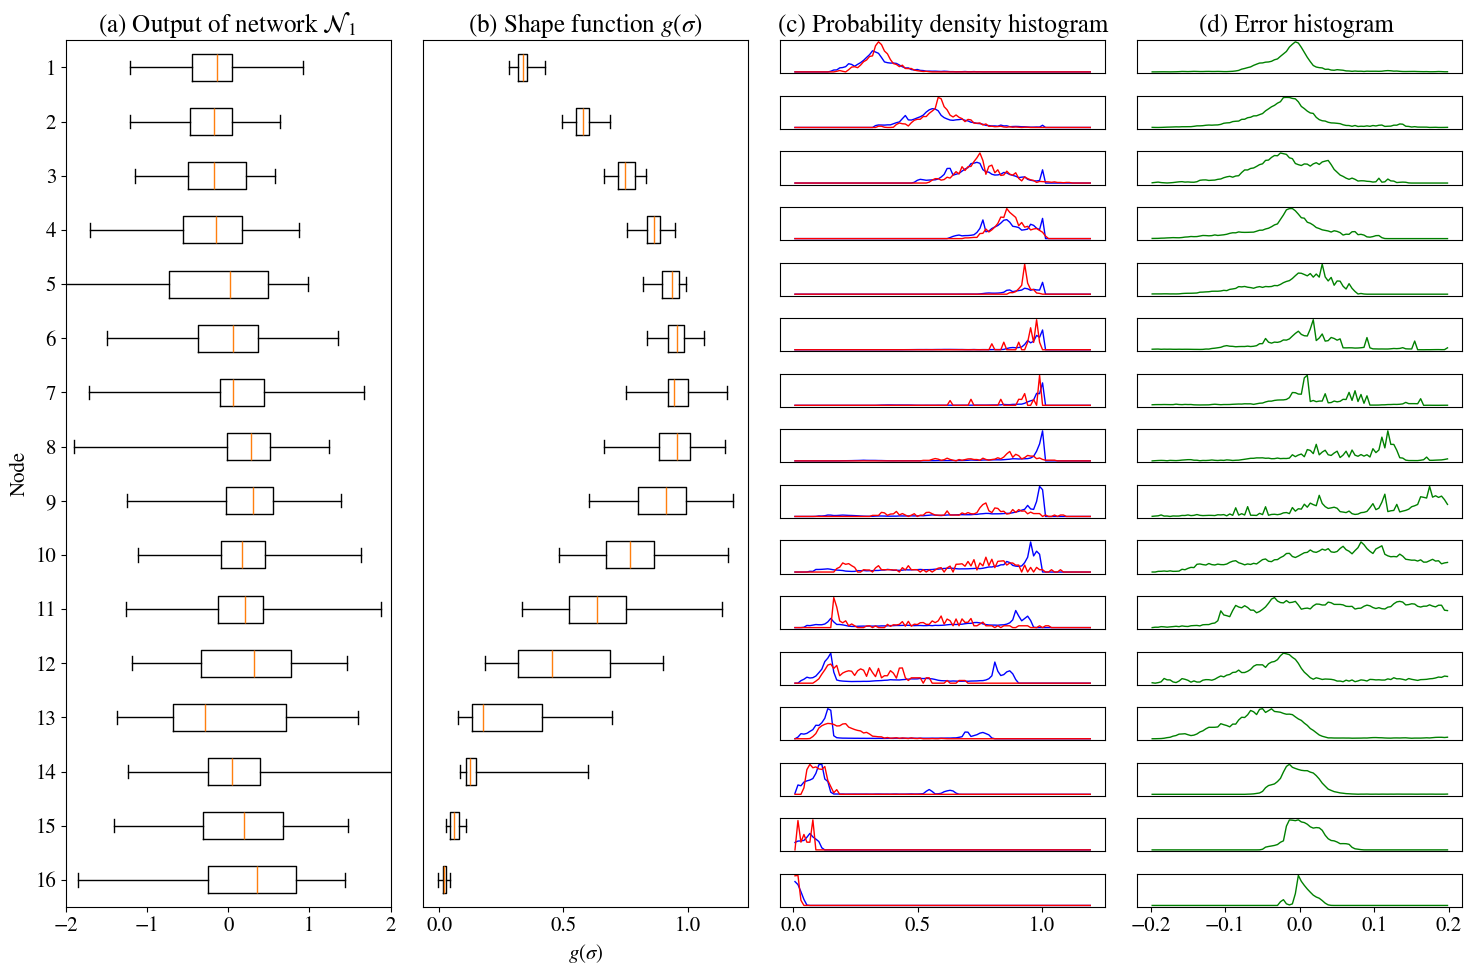

In [19]:
## figure histograms 
performance_sigma_point2(model, x, valid_x, y, valid_y, k_mean, k_std)

**Symbolic regression performed worse than the other machine learning methods in both predictive accuracy and computational speed**. Error bars in both box and whisker plots reveal large variability within the predictions and running the model requires 80–120 minutes to run. **However, where it lacks in performance it makes up in interpretability**. The resulting equations are easy to understand and can be seamlessly integrated into larger ecosystem models without significant computational cost. 

There are additional measures that could possibly improve overall performace, such as increasing the number of iterations or including more unary operators within the equation search. However, with each you will be increasing computational cost even further


### 3.1.2 Model 1: Statistics

In [20]:
y_pred_test = model.predict(valid_x)

rmse = np.sqrt(np.mean((y_pred_test - valid_y) ** 2))

print("RMSE:", rmse)

RMSE: 0.8644306002927096


In [21]:
# Denormalize predicted and observed values
y_pred_denorm = np.std(np.exp(y_pred_test * k_std + k_mean))
valid_y_denorm = np.std(np.exp(valid_y * k_std + k_mean))

# RMSE calculation 
rmse = np.sqrt(np.mean((y_pred_denorm - valid_y_denorm) ** 2))

print("RMSE (denormalized):", rmse)

RMSE (denormalized): 0.01629994229621362


## 3.2 Model 2: Raw Inputs 

In our original hypothesis, we assumed that normalizing the data during preprocessing was unnecessary since symbolic regression does not rely on gradient descent. However, due to the large discrepancies in the raw, unnormalized data, we found that the varying scales of input parameters disproportionately influenced the search process, causing some underlying relationships to be overlooked.

### 3.2.1 Data and Model Preparation

In [25]:
def preprocess_train_pysr(data_load):
    # Compute means and standard deviations for the first 4 columns (features)
    l_mean, l_std = np.mean(data_load[:, 0]), np.std(data_load[:, 0])
    h_mean, h_std = np.mean(data_load[:, 1]), np.std(data_load[:, 1])
    t_mean, t_std = np.mean(data_load[:, 2]), np.std(data_load[:, 2])
    hb_mean, hb_std = np.mean(data_load[:, 3]), np.std(data_load[:, 3])

    # Compute means and standard deviations for the output columns
    k_mean = np.mean(data_load[:, 4:], axis=0)
    k_std = np.std(data_load[:, 4:], axis=0)

    # Split into inputs (x) and outputs (y) without modifying the original values
    x = data_load[:, :4]   # First 4 columns as input features
    y = data_load[:, 4:]   # Remaining columns as output labels

    # Store feature statistics
    stats = np.array([l_mean, l_std, h_mean, h_std, t_mean, t_std, hb_mean, hb_std])

    return data_load, x, y, stats, k_mean, k_std


In [26]:
# there are 16 levels (1 at bottom, 16 at top)
mm1=0; mm2=16  #0; 16
# apply ind7 to keep only the profiles that meet the filtering criteria
# Training uses only 4 inputs: Coriolis parameter (l0), buoyancy flux (b00), surface friction velocity (ustar0) and boundary layer depth (h0)
data_load_main=np.zeros([len(h0[ind7]),4+mm2-mm1])
data_load_main[:,0]=l0[ind7]
data_load_main[:,1]=b00[ind7]
data_load_main[:,2]=ustar0[ind7]
data_load_main[:,3]=h0[ind7]
data_load_main[:,4:(mm2-mm1+4)]=SF0[ind7,mm1:mm2]

data_forc=np.zeros([len(ind7),3])
data_forc[:,0]=lat0[ind7]
data_forc[:,1]=heat0[ind7]
data_forc[:,2]=tx0[ind7]

data_load3=copy.deepcopy(data_load_main)

print('started')


## we do not need to normalize data for this process 
data, x,y, stats, k_mean, k_std=preprocess_train_pysr(data_load3)  


started


In [27]:
# loading the validation data wihtout normalization

url = "https://nyu1.osn.mghpcc.org/leap-pangeo-manual/GOTM/data_testing_4_paper.txt"
df = pd.read_csv(url, delim_whitespace=True, header=None)
valid_data = df.iloc[:, 3:].values  

# Filtering the data
ind3 = np.where(valid_data[:, 3] > 29)[0]
ind4 = np.where(valid_data[:, 3] < 301)[0]
ind = np.intersect1d(ind3, ind4)

# Extract features without normalization
valid_x = valid_data[ind, 0:4]  

# Extract targets without log transformation or normalization
valid_y = valid_data[ind, 5:]  

# No standardization, no log transformation
k_mean_test = np.zeros(16)  


In [28]:
## model set up is same as before 

default_pysr_params = dict(
    populations=30,  # default
    model_selection="best", ## 'best' selects the candidate model with the highest score among expressions with a loss better than at least 1.5x the most accurate model. 
)

# Create the PySRRegressor model with output directory
model = PySRRegressor(
    niterations=30,  # Reduced from 100 for computation time  
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["square", "sin"], 
    **default_pysr_params,
    batching=True,  # Enable batching  
    batch_size=64,
    verbosity=0,  # Suppress output - this can bog down the notebook
    output_directory=cwd_pysrout,  # Set output directory here
)


In [30]:
# NOTE : we have commented this out as running the model can take a long time
## in the next cell we are going to load a previous model
#model.fit(x, y) 

/srv/conda/envs/notebook/lib/python3.12/site-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


PySRRegressor.equations_ = [
[
	    pick     score                                           equation  \
	0         0.000000                                       0.0034946378   
	1         0.015110                                    x2 * 0.15091008   
	2         0.019587                           square(x2 + 0.036893304)   
	3   >>>>  0.257981                  (x1 / 3.329513e-5) + 0.0034743338   
	4         0.019981              ((193.9641 * x3) * x1) + 0.0032672682   
	5         0.016028     ((x3 / 0.0069845705) * x1) + (0.12892564 * x2)   
	6         0.008518  ((x3 * (x1 * 193.9641)) + square(x2)) + 0.0023...   
	7         0.052534  ((193.9641 * x1) * x3) + ((0.15100126 * x2) + x0)   
	8         0.019263  square(x2 + (((x1 * 1755.8552) + (x0 + x0)) * ...   
	9         0.000056  sin(square(x2 + (((x1 * 1755.8552) + (x0 + x0)...   
	10        0.005241  x0 + square(x2 + ((((x1 * 1755.8552) + x0) + x...   
	11        0.003796  x0 + square(sin(x2 + (((x1 * 1755.8552) + (x0 ...   
	12        0.057799  square(sin(x0 + ((x3 * (x0 + (x1 * 1755.8552))...   
	
	        loss  complexity  
	0   0.000016           1  
	1   0.000016           3  
	2   0.000016           4  
	3   0.000012           5  
	4   0.000012           7  
	5   0.000011           9  
	6   0.000011          10  
	7   0.000011          11  
	8   0.000010          12  
	9   0.000010          13  
	10  0.000010          14  
	11  0.000010          15  
	12  0.000009          17  
], [
	    pick     score                                           equation  \
	0         0.000000                                        0.011927908   
	1         0.085520                                            x3 * x0   
	2         0.000046                                       sin(x3 * x0)   
	3         0.245254                   0.01244074 + (x1 / 1.4371699e-5)   
	4   >>>>  0.140625             (x2 + (x1 / 7.080205e-6)) * 0.55022526   
	5         0.010427  (x2 * 0.5218202) + ((x1 / -0.65346) / -1.61996...   
	6         0.004733  ((x1 / -0.65346) / (x1 + -1.6199636e-5)) + (x2...   
	7         0.004687  (x2 * 0.5218202) + ((x1 / -0.65346) / ((x1 + x...   
	8         0.003035  (x2 + ((x1 + x1) / 1.3897986e-5)) * square(-0....   
	9         0.112529  ((x1 / -0.65346) / ((x1 + (x1 / 0.07061858)) +...   
	10        0.007994  ((x1 + x1) / 1.4283509e-5) + (square((x1 / (x1...   
	11        0.067925  x1 + (0.5487073 * (x2 + ((x1 + x1) / ((x1 / ((...   
	12        0.001415  (x2 + ((x1 + x1) / 1.3897986e-5)) * ((x1 / (x2...   
	13        0.006951  (x2 + ((x1 + x1) / 1.3897986e-5)) * (square(((...   
	
	        loss  complexity  
	0   0.000113           1  
	1   0.000095           3  
	2   0.000095           4  
	3   0.000074           5  
	4   0.000056           7  
	5   0.000055           9  
	6   0.000055          11  
	7   0.000054          13  
	8   0.000054          14  
	9   0.000048          15  
	10  0.000047          18  
	11  0.000044          19  
	12  0.000043          26  
	13  0.000043          29  
], [
	    pick     score                                           equation  \
	0         0.000000                                        0.028930247   
	1         0.000077                                   x0 + 0.028851494   
	2         0.186987                  (x1 + 7.410483e-8) / 2.6213568e-6   
	3         0.000150           ((x1 + 7.410483e-8) / 2.6213568e-6) + x0   
	4         0.001341  ((x1 + 7.410483e-8) / 2.6213568e-6) + (x0 / 0....   
	5   >>>>  0.229752  (8.993866e-8 + x1) / ((x2 / square(x3)) + 1.62...   
	6         0.000944  (8.993866e-8 + x1) / (1.6209152e-6 + (x2 / squ...   
	7         0.006694  ((x1 + 8.993866e-8) / ((x2 / square(x3)) + 1.6...   
	8         0.000155  (((8.993866e-8 + x1) / (1.6209152e-6 + (x2 / s...   
	9         0.011453  (x1 / ((((0.0008771643 - (((x1 / 0.0008771643)...   
	10        0.039675  sin(sin((x1 / (((((0.0008771643 - ((x1 / 0.000...   
	11        0.000286  sin(sin(sin((x1 / (((((0.0008771643 - ((x1 / 0...   
	
	        loss  complexity  
	0   

In [ ]:
# Define the run_directory. 
#ML_Project2_Team1/pysrout/20250325_044928_9qA1hR

run_directory = cwd_pysrout + "/20250325_044928_9qA1hR" ## this file extention refers to the most recent model. 

print(run_directory)

# Load model from the checkpoint - this can be finnicky, double check your file paths if you recieve an error
model = PySRRegressor.from_file(run_directory=run_directory)

In [38]:
print(model)

PySRRegressor.equations_ = [
[
	    pick     score                                           equation  \
	0         0.000000                                       0.0034946378   
	1         0.015110                                    x2 * 0.15091008   
	2         0.019587                           square(x2 + 0.036893304)   
	3   >>>>  0.257981                  (x1 / 3.329513e-5) + 0.0034743338   
	4         0.019981              ((193.9641 * x3) * x1) + 0.0032672682   
	5         0.016028     ((x3 / 0.0069845705) * x1) + (0.12892564 * x2)   
	6         0.008518  ((x3 * (x1 * 193.9641)) + square(x2)) + 0.0023...   
	7         0.052534  ((193.9641 * x1) * x3) + ((0.15100126 * x2) + x0)   
	8         0.019263  square(x2 + (((x1 * 1755.8552) + (x0 + x0)) * ...   
	9         0.000056  sin(square(x2 + (((x1 * 1755.8552) + (x0 + x0)...   
	10        0.005241  x0 + square(x2 + ((((x1 * 1755.8552) + x0) + x...   
	11        0.003796  x0 + square(sin(x2 + (((x1 * 1755.8552) + (x0 ...   
	12    

### 3.2.2 Figures

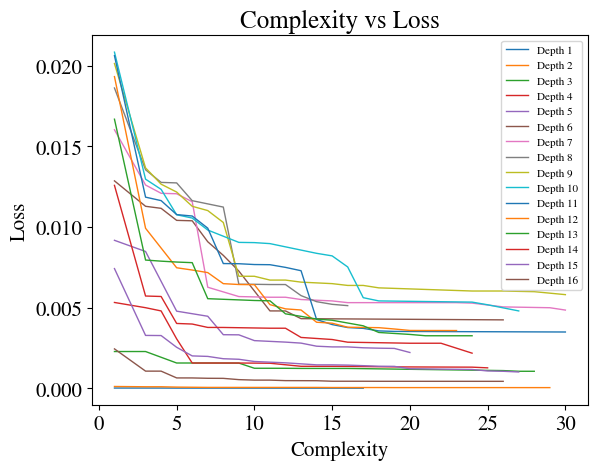

In [33]:
# Loop through each depth in model.equations_
for i in range(len(model.equations_)):
    depth1 = model.equations_[i]  # Extract the current depth's data

    # Extract the values for complexity and loss
    complexity_values = depth1['complexity']
    loss_values = depth1['loss']

    # Create a line plot
    plt.plot(complexity_values, loss_values, label=f'Depth {i+1}')

# Labels and title
plt.xlabel('Complexity')
plt.ylabel('Loss')
plt.title('Complexity vs Loss')

# Add legend
plt.legend()

# Show plot
plt.show()


In [36]:
def performance_mod2(model, x, valid_x, y, valid_y):

    # Set plot styles
    plt.rcParams['font.size'] = 15
    plt.rcParams['lines.linewidth'] = 1
    plt.rcParams['legend.fontsize'] = 8
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['mathtext.fontset'] = 'stix'

    # Get predictions
    y_pred_test = model.predict(valid_x)

    plt.figure(figsize=(8, 10))  

    ind = np.arange(0, 16)
    ind_tick = np.arange(1, 17)[::-1]

    # Subplot 1: Boxplot of network output differences
    plt.boxplot(
        [valid_y[:, i] - y_pred_test[:, i] for i in range(16)], 
        vert=False, 
        positions=ind, 
        showfliers=False, 
        whis=(5, 95), 
        widths=0.5
    )

    plt.xlim([-0.5, 0.5])
    plt.yticks(ind, ind_tick)
    plt.title(r'(a) Output of network $\mathcal{N}_1$')
    plt.ylabel('Node')
    plt.xlabel('Difference (True - Predicted)')

    plt.tight_layout()
    plt.show()


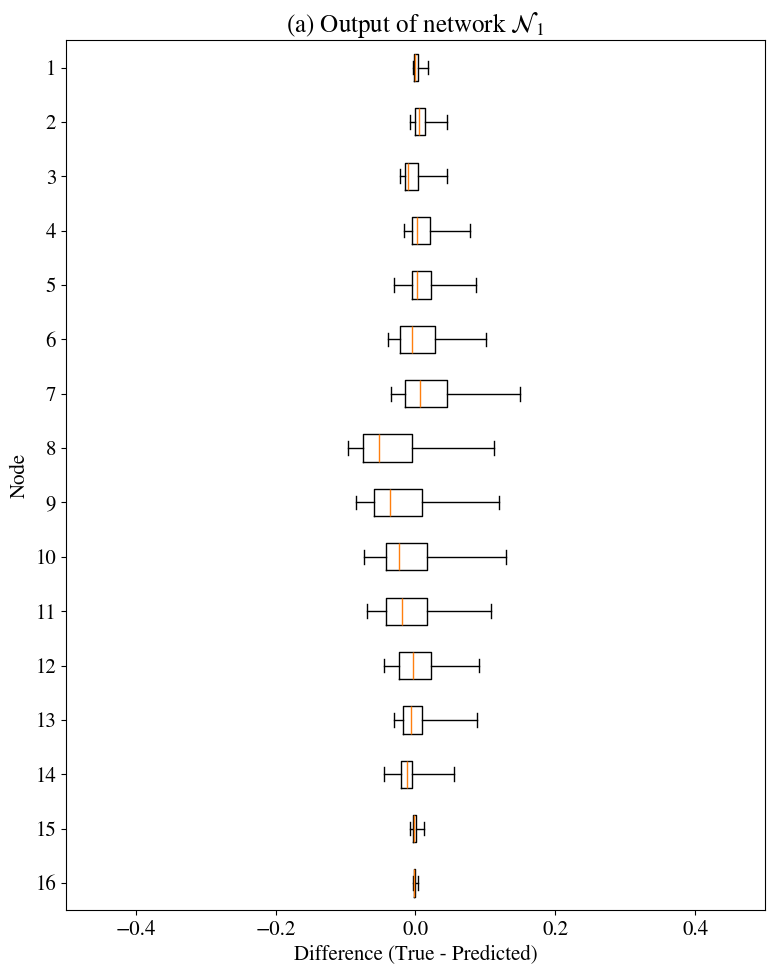

In [35]:
performance_mod2(model, x, valid_x, y, valid_y)

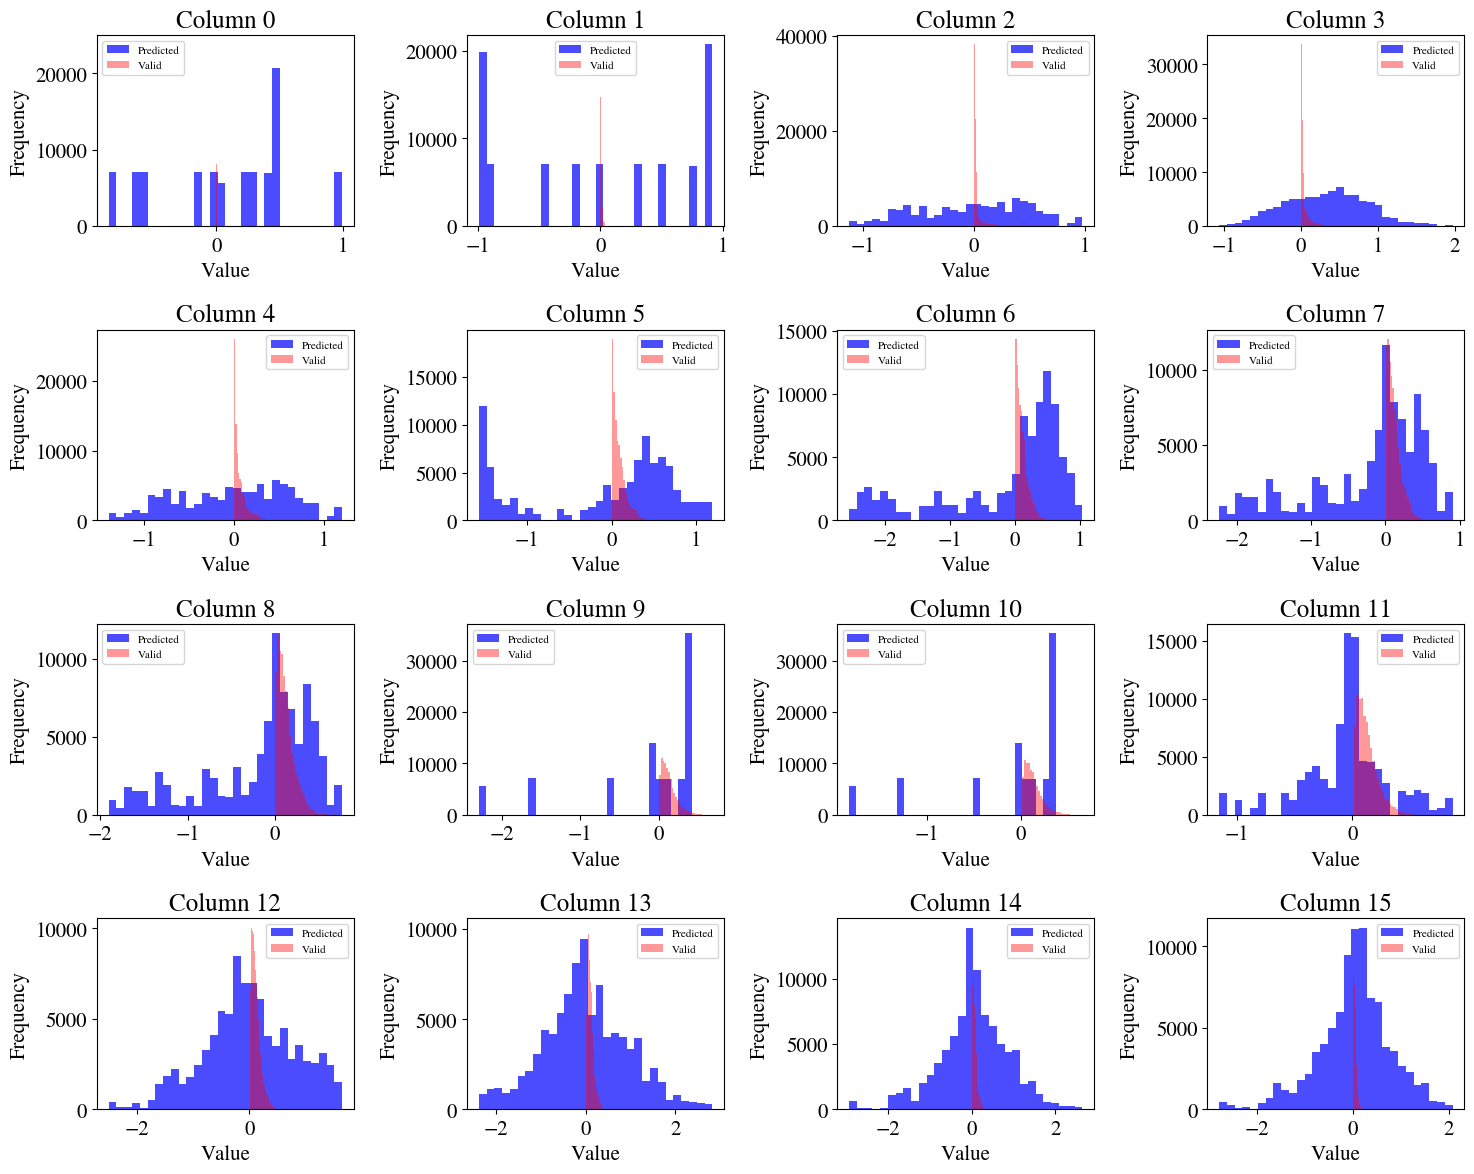

In [45]:
fig, axes = plt.subplots(4, 4, figsize=(15, 12))  # 4x4 grid of subplots

for i in range(16):
    ax = axes[i // 4, i % 4]  # Determine subplot position
    ax.hist(y_pred_test[:, i], bins=30, alpha=0.7, color='b', label='Predicted')  # Blue histogram
    ax.hist(valid_y[:, i], bins=30, alpha=0.4, color='r', label='Valid')  # Red histogram with transparency
    ax.set_title(f'Column {i}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend()  # Add legend to differentiate

plt.tight_layout()
plt.show()

While the validation error is small, the shape function is not preserved. Additionally, artifacts from data masking affect performance. Despite the low loss, a comparison of predicted and observed validation measurements reveals that the model is not functioning as expected.

# 4. Conclusion

<style>
  table { width: 60%; border-collapse: collapse; font-size: 14px; }
  th, td { border: 1px solid black; padding: 5px; text-align: center; }
</style>

<table>
  <tr>
    <th>Method</th>
    <th>Performance</th>
    <th>Complexity</th>
    <th>Explainability</th>
  </tr>
  <tr>
    <td><b>Neural Network</b></td>
    <td>Medium</td>
    <td>Low</td>
    <td>Low</td>
  </tr>
  <tr>
    <td><b>SVGP</b></td>
    <td>High</td>
    <td>Medium</td>
    <td>Medium</td>
  </tr>
  <tr>
    <td><b>Symbolic Regression</b></td>
    <td>Low</td>
    <td>High</td>
    <td>High</td>
  </tr>
</table>


Our study compared different machine learning methods for predicting shape function values, focusing on Stochatic Variational Gaussian Process and Symbolic Regression.

**Key Findings:**

**Gaussian Process Regression (GPR) vs. Neural Networks**
- GPR captures data dependencies explicitly through kernel functions, improving prediction accuracy.
- SVGP training took 35.6 minutes, achieving a validation RMSE of 0.5037.
- GPR outperformed the original neural network, particularly in nodes 1–6, where predictions were more concentrated and errors were minimal. However, for nodes 10–13, improvements were marginal due to challenges in capturing multi-modal distributions.

**Symbolic Regression**
- Symbolic regression performed worse than other ML methods in predictive accuracy and computational speed (80–120 min runtime).
- Despite poor performance, it offers high interpretability, making the derived equations easily integrable into ecosystem models without computational overhead.
- Potential improvements (e.g., more iterations, additional unary operators) would increase computational cost further.


**Feature Importance Analysis**
- SHAP analysis revealed Coriolis force (I₀) and Surface buoyancy flux (b₀₀) were the most influential features.
- SHAP results exhibited wide variability, limiting interpretability despite providing insights into feature interactions.
- Symbolic Regression supported these findings, as Coriolis force and Surface buoyancy were the only two features included in every 'best' equation
  

**Complexity, Performance, Interpretability**
While promising, the underperformance and high computational cost of symbolic regression limit its practicality in this context. However, further improvements could enhance its effectiveness. Ultimately, combining GPR with SHAP analysis provides a balance between accuracy and interpretability, outperforming traditional black-box ML models in both predictive performance and feature understanding.